<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [48]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 790 (delta 86), reused 27 (delta 27), pack-reused 649 (from 4)
Receiving objects: 100% (790/790), 91.11 MiB | 9.21 MiB/s, done.
Resolving deltas: 100% (412/412), done.
Updating files: 100% (26/26), done.
/content/DATCapstone/data/DATCapstone/data


In [49]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [50]:
df

Date        Open        High         Low       Close    Volume  \
149  2021-09-30  140.983670  141.690258  138.648004  138.863907  89056700   
152  2021-10-01  139.256450  140.257452  136.518433  139.992477  94639600   
155  2021-10-04  139.119037  139.560665  135.694064  136.547852  98322000   
158  2021-10-05  136.891371  139.590139  136.763788  138.481186  80861100   
161  2021-10-06  136.871718  139.501783  135.792205  139.354584  83221100   
...         ...         ...         ...         ...         ...       ...   
8062 2025-01-27  394.799988  406.690002  389.000000  397.149994  58125500   
8072 2025-01-28  396.910004  400.589996  386.500000  398.089996  48910700   
8082 2025-01-29  395.209991  398.589996  384.480011  389.100006  68033600   
8092 2025-01-30  410.779999  412.500000  384.410004  400.279999  98092900   
8102 2025-01-31  401.529999  419.989990  401.339996  404.600006  83568200   

      Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
149         0.0           0.0           23921.991                    4.7  ...   
152         0.0           0.0           24777.038                    4.5  ...   
155         0.0           0.0           24777.038                    4.5  ...   
158         0.0           0.0           24777.038                    4.5  ...   
161         0.0           0.0           24777.038                    4.5  ...   
...         ...           ...                 ...                    ...  ...   
8062        0.0           0.0           29723.864                    4.0  ...   
8072        0.0           0.0           29723.864                    4.0  ...   
8082        0.0           0.0           29723.864                    4.0  ...   
8092        0.0           0.0           29723.864                    4.0  ...   
8102        0.0           0.0           29723.864                    4.0  ...   

       emb_763   emb_764   emb_765   emb_766   emb_767  Target_1day  \
149        NaN       NaN       NaN       NaN       NaN     1.128571   
152        NaN       NaN       NaN       NaN       NaN    -3.444626   
155        NaN       NaN       NaN       NaN       NaN     1.933334   
158        NaN       NaN       NaN       NaN       NaN     0.873398   
161        NaN       NaN       NaN       NaN       NaN     1.265976   
...        ...       ...       ...       ...       ...          ...   
8062  1.174326 -0.262426  0.298183  0.182200  0.388200     0.940002   
8072  0.084330 -0.354550 -0.611864 -0.449780  0.584349    -8.989990   
8082  0.827862 -0.620100 -0.024186 -0.439615  0.781107    11.179993   
8092  1.383147 -0.616897 -0.145329 -0.418483  0.636253     4.320007   
8102  0.658588 -0.312093 -0.158066 -0.211410  0.834208          NaN   

      Target_1week  Target_1month  Target_1year  Ticker  
149       1.756653      10.863785      9.008606    AAPL  
152       0.245331       7.016815      0.616699    AAPL  
155       3.601639       9.637100     -0.162491    AAPL  
158       0.392532       8.744034      2.098389    AAPL  
161      -1.069687       9.313263      4.827057    AAPL  
...            ...            ...           ...     ...  
8062           NaN            NaN           NaN    TSLA  
8072           NaN            NaN           NaN    TSLA  
8082           NaN            NaN           NaN    TSLA  
8092           NaN            NaN           NaN    TSLA  
8102           NaN            NaN           NaN    TSLA  

[8103 rows x 817 columns]

In [51]:
!pip install tensorflow


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Fill missing values
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)

# Sequence creation
def create_sequences_labeled(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i - look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Main training & evaluation function
def run_lstm_by_ticker(df, ticker, target, look_back=30, epochs=20, batch_size=32):
    df_ticker = df[df['Ticker'] == ticker].copy().sort_values(by='Date')
    df_ticker = df_ticker.dropna(subset=[target])


    feature_cols = [col for col in df_ticker.columns if 'Target' not in col and col not in ['Date', 'Ticker']]
    df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

    X = df_ticker[feature_cols].values
    y = df_ticker[target].values

    if len(X) <= look_back + 30:
        print(f"[{ticker}] {target}: Not enough data. Skipping.")
        return

    X_seq, y_seq = create_sequences_labeled(X, y, look_back)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

    # Create sequences
    nsamples, nsteps, nfeatures = X_train.shape
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, nfeatures)).reshape(nsamples, nsteps, nfeatures)

    nsamples_val = X_val.shape[0]
    X_val_scaled = scaler.transform(X_val.reshape(-1, nfeatures)).reshape(nsamples_val, nsteps, nfeatures)

    nsamples_test = X_test.shape[0]
    X_test_scaled = scaler.transform(X_test.reshape(-1, nfeatures)).reshape(nsamples_test, nsteps, nfeatures)

    X_train_seq = X_train_scaled
    y_train_seq = y_train
    X_val_seq = X_val_scaled
    y_val_seq = y_val
    X_test_seq = X_test_scaled
    y_test_seq = y_test


    # Define and train model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop],
        verbose=0
    )

    # Predict and evaluate
    y_pred = model.predict(X_test_seq).flatten()
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)

    print(f"\n[{ticker}] Target: {target}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_seq, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"LSTM Prediction – {ticker} | {target}")
    plt.xlabel('Sample Index')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save only MSFT plots
    if ticker == 'MSFT':
        filename = f'msft_lstm_{target}.png'
        plt.savefig(filename)

    plt.show()

    return history


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

[MSFT] Target: Target_1day
MAE : 12.0055
RMSE: 14.3328
R²   : -10.7839


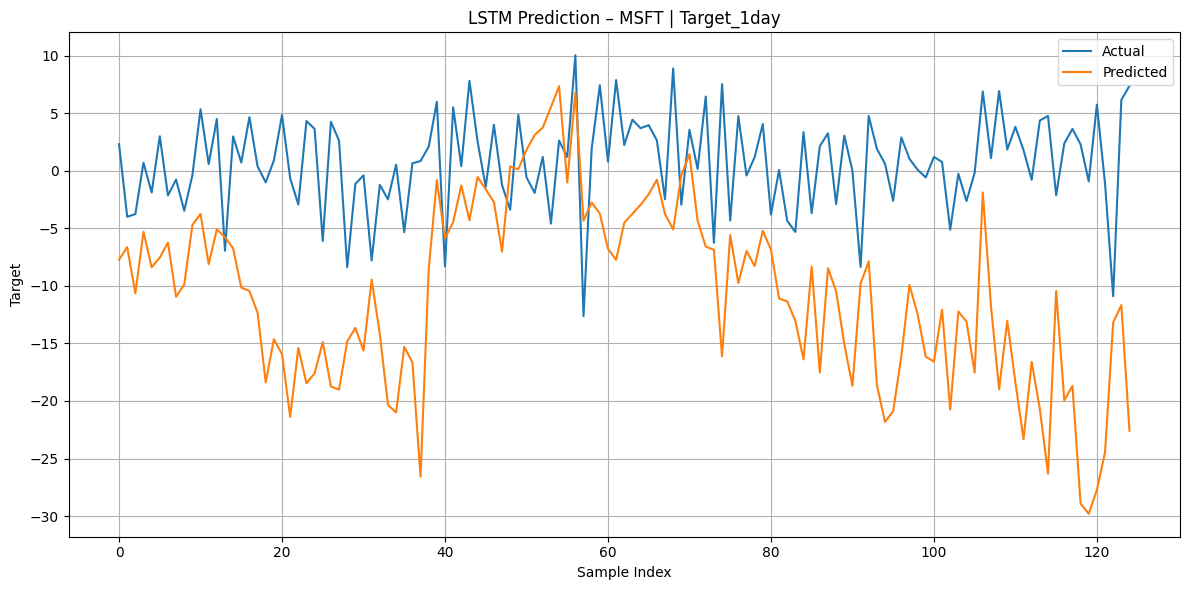

Epoch 1: Train Loss = 30.1853 | Validation Loss = 87.1063
Epoch 2: Train Loss = 25.5287 | Validation Loss = 63.6027
Epoch 3: Train Loss = 23.9847 | Validation Loss = 50.6204
Epoch 4: Train Loss = 23.3945 | Validation Loss = 42.8381
Epoch 5: Train Loss = 22.3507 | Validation Loss = 65.0329
Epoch 6: Train Loss = 21.9115 | Validation Loss = 41.2433
Epoch 7: Train Loss = 21.2670 | Validation Loss = 45.6736
Epoch 8: Train Loss = 20.3806 | Validation Loss = 52.1478
Epoch 9: Train Loss = 19.3516 | Validation Loss = 49.5380


In [53]:
# Validation 성능 확인용
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1day')

# history가 제대로 반환되었는지 확인
if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

[MSFT] Target: Target_1week
MAE : 10.5976
RMSE: 12.8563
R²   : -1.4154


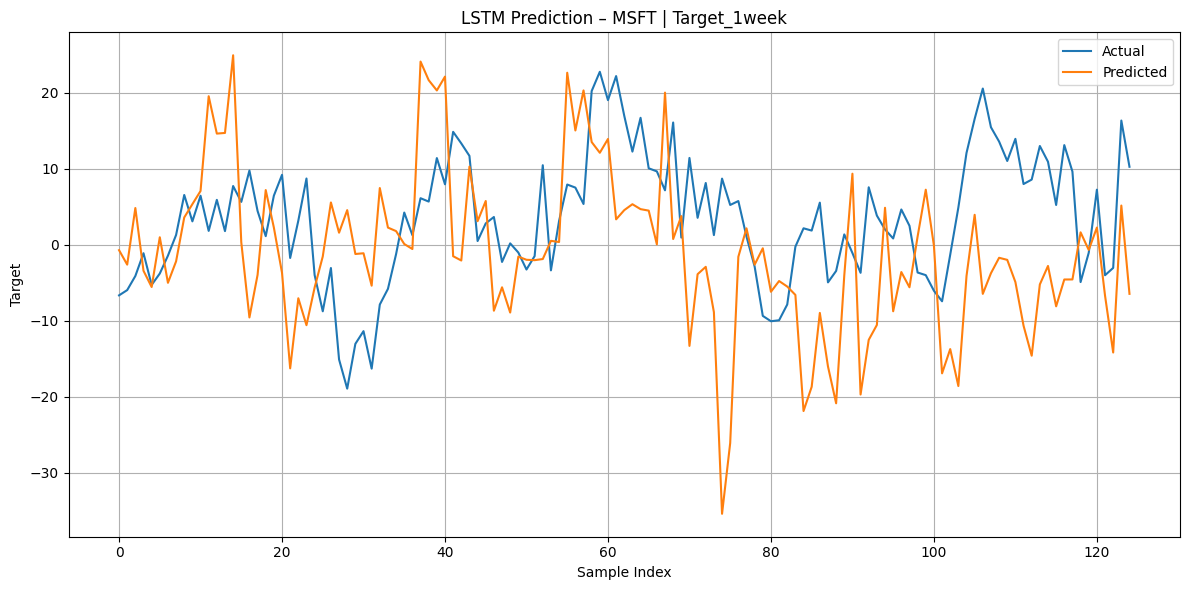

Epoch 1: Train Loss = 120.2951 | Validation Loss = 192.2272
Epoch 2: Train Loss = 98.9451 | Validation Loss = 493.9980
Epoch 3: Train Loss = 86.7499 | Validation Loss = 883.5620
Epoch 4: Train Loss = 83.1080 | Validation Loss = 533.6566


In [54]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1week')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

[MSFT] Target: Target_1month
MAE : 76.7613
RMSE: 97.5993
R²   : -32.7722


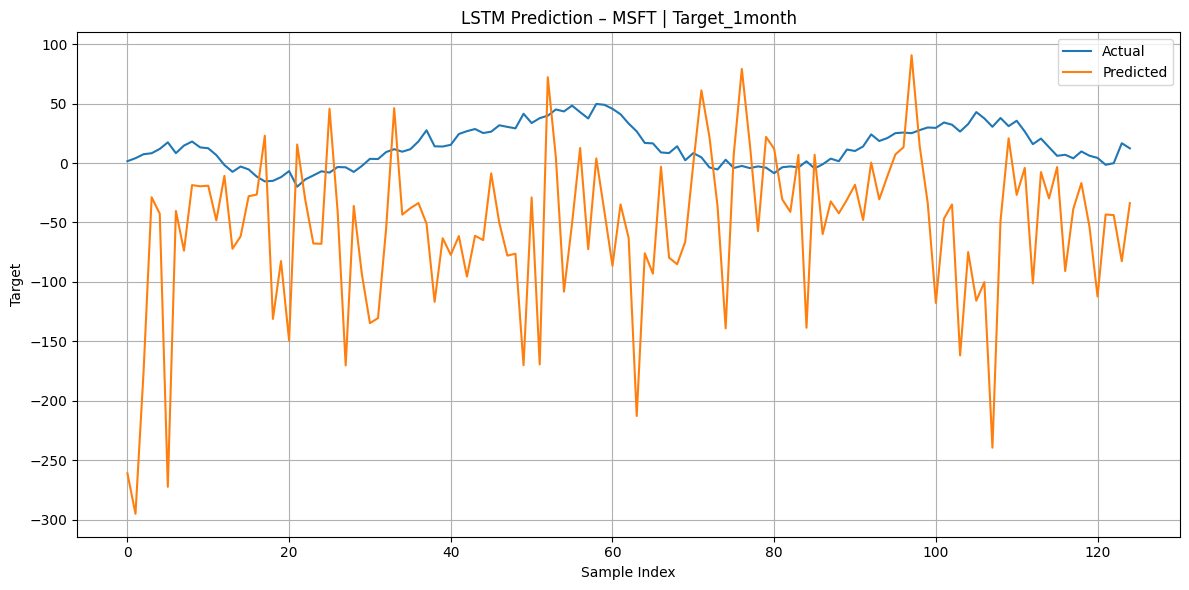

Epoch 1: Train Loss = 296.7592 | Validation Loss = 4907.6089
Epoch 2: Train Loss = 177.1285 | Validation Loss = 7409.2236
Epoch 3: Train Loss = 116.6193 | Validation Loss = 320.3822
Epoch 4: Train Loss = 87.8408 | Validation Loss = 351.1104
Epoch 5: Train Loss = 67.8693 | Validation Loss = 965.1308
Epoch 6: Train Loss = 48.5476 | Validation Loss = 564.5826


In [55]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1month')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

[MSFT] Target: Target_1year
MAE : 148.5024
RMSE: 158.8991
R²   : -39.5479


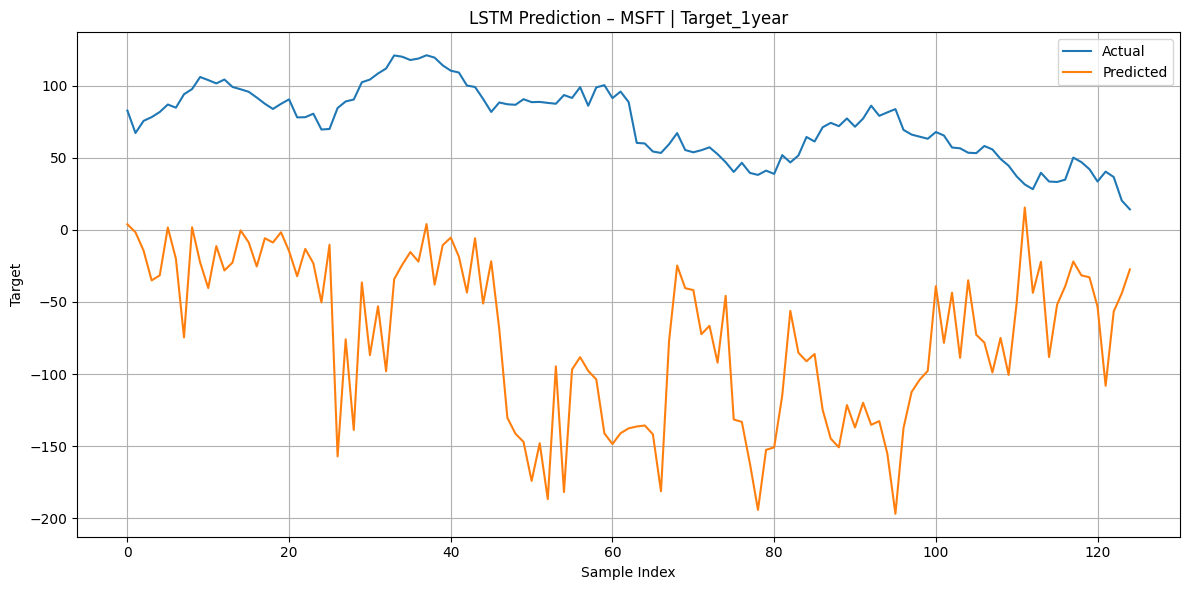

Epoch 1: Train Loss = 4807.8311 | Validation Loss = 7841.5308
Epoch 2: Train Loss = 2320.7693 | Validation Loss = 4200.0439
Epoch 3: Train Loss = 1510.5370 | Validation Loss = 2993.3181
Epoch 4: Train Loss = 1859.0667 | Validation Loss = 2698.2178
Epoch 5: Train Loss = 973.6318 | Validation Loss = 3441.6682
Epoch 6: Train Loss = 586.0297 | Validation Loss = 4983.9258
Epoch 7: Train Loss = 344.1196 | Validation Loss = 4973.6162


In [56]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1year')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


In [57]:
print("Date dtype:", df['Date'].dtype)
print("Ticker column exists:", 'Ticker' in df.columns)
print("Target columns:", [col for col in df.columns if 'Target' in col])
print("Missing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("Column types:")
print(df.dtypes.value_counts())


Date dtype: datetime64[ns]
Ticker column exists: True
Target columns: ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']
Missing values (top 10):
Ticker     0
emb_756    0
emb_755    0
emb_754    0
emb_753    0
emb_752    0
emb_751    0
emb_750    0
emb_749    0
emb_748    0
dtype: int64
Column types:
float64           814
datetime64[ns]      1
int64               1
object              1
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

[AAPL] Target: Target_1day
MAE : 2.3265
RMSE: 2.9673
R²   : -0.7355


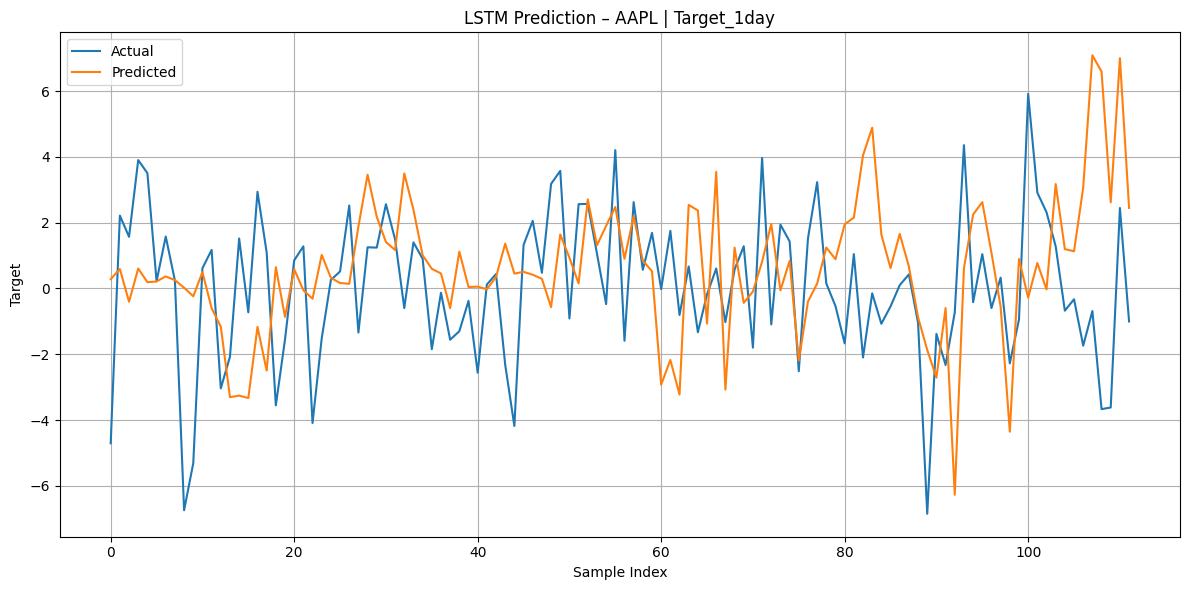

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

[AAPL] Target: Target_1week
MAE : 5.9017
RMSE: 7.0317
R²   : -0.4828


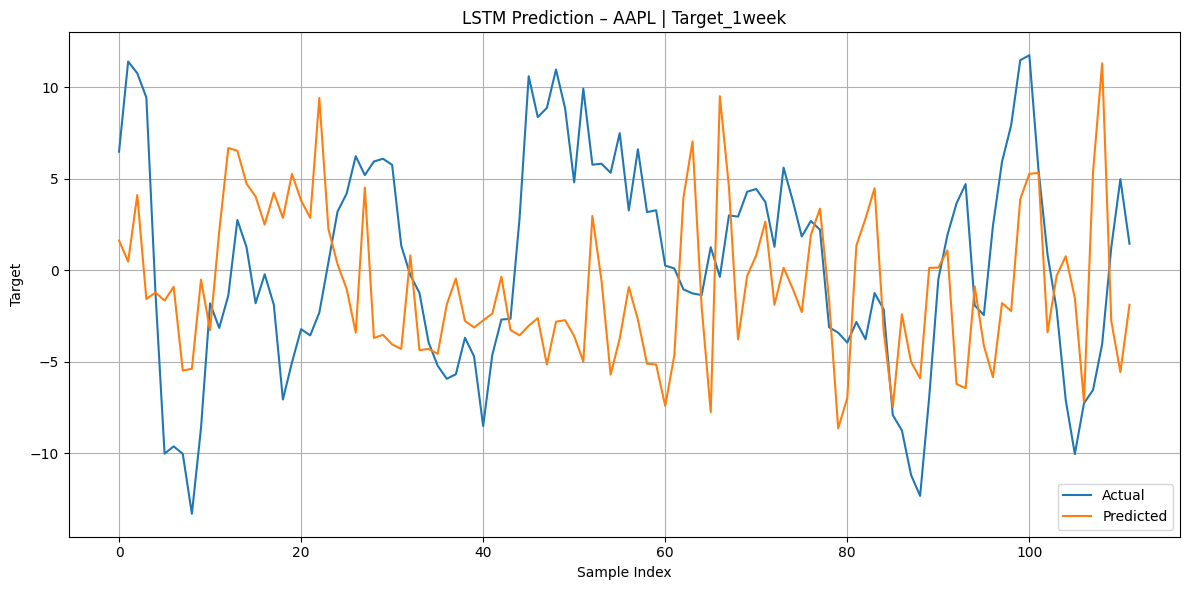

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

[AAPL] Target: Target_1month
MAE : 12.3344
RMSE: 15.7339
R²   : -1.9378


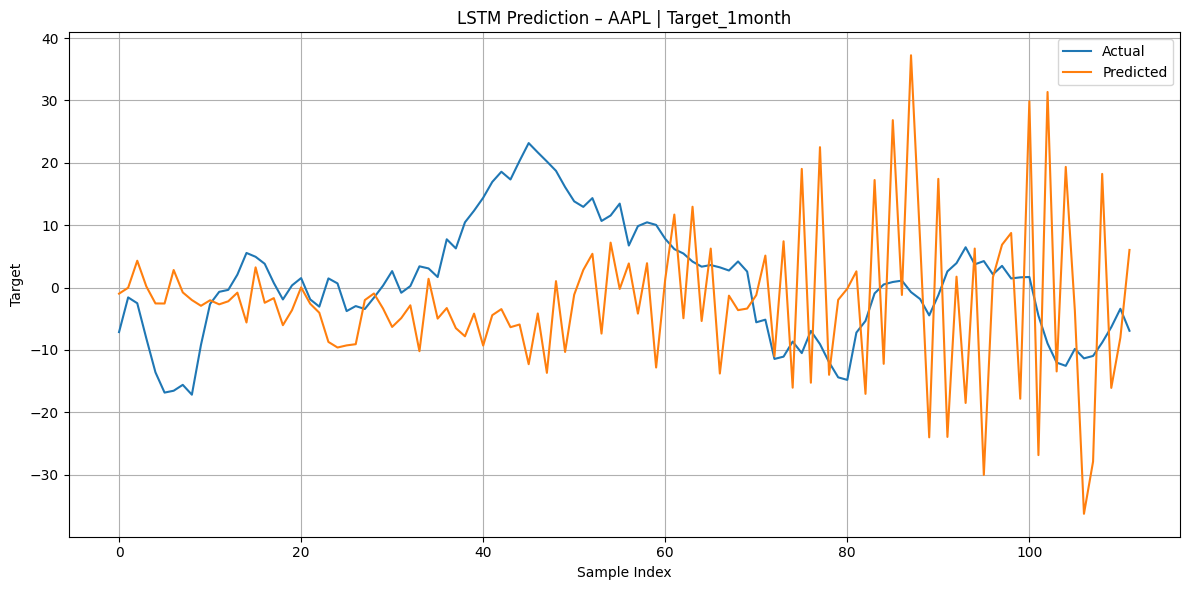

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

[AAPL] Target: Target_1year
MAE : 26.4373
RMSE: 29.5025
R²   : -9.5227


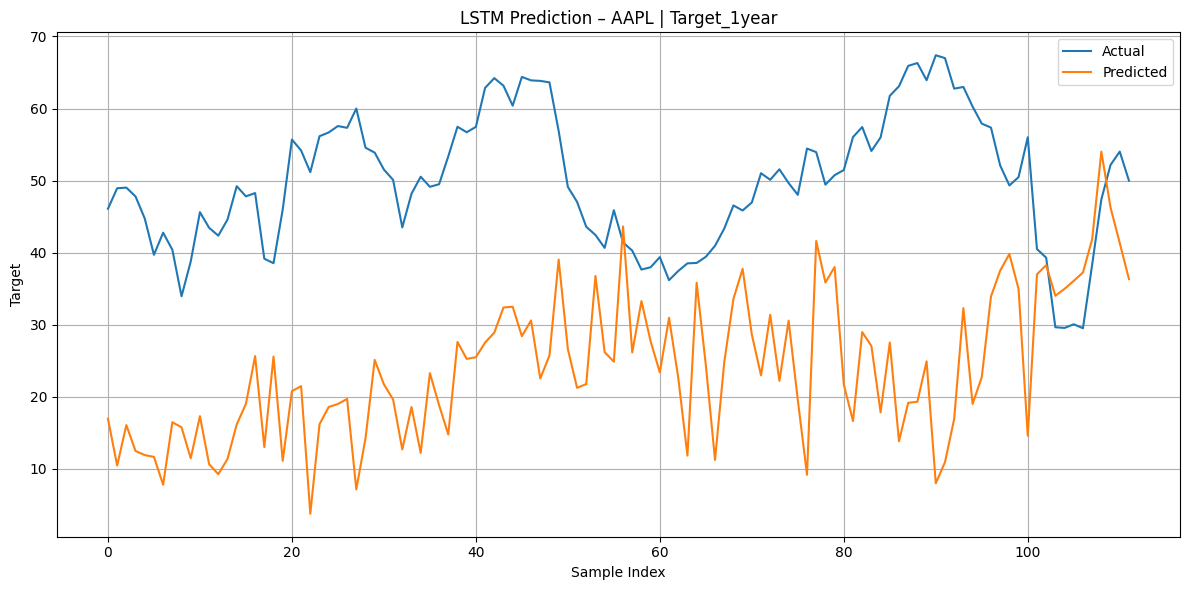

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

[AMD] Target: Target_1day
MAE : 3.5375
RMSE: 4.8436
R²   : -0.7458


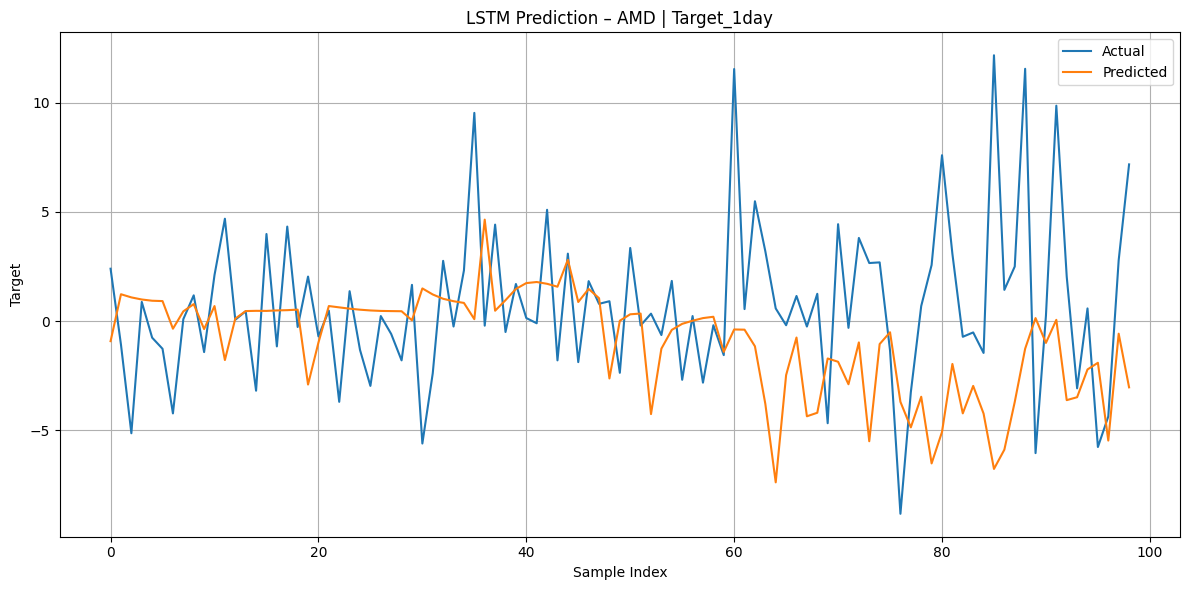

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AMD] Target: Target_1week
MAE : 9.4460
RMSE: 13.6301
R²   : -1.8477


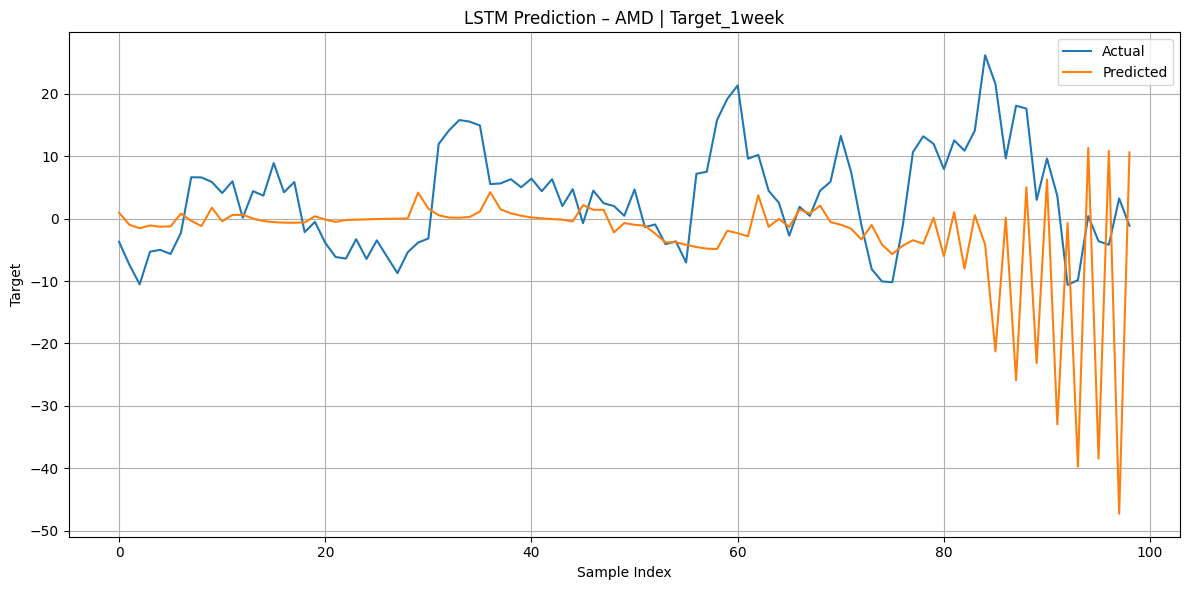

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step

[AMD] Target: Target_1month
MAE : 15.1888
RMSE: 17.7497
R²   : -1.3952


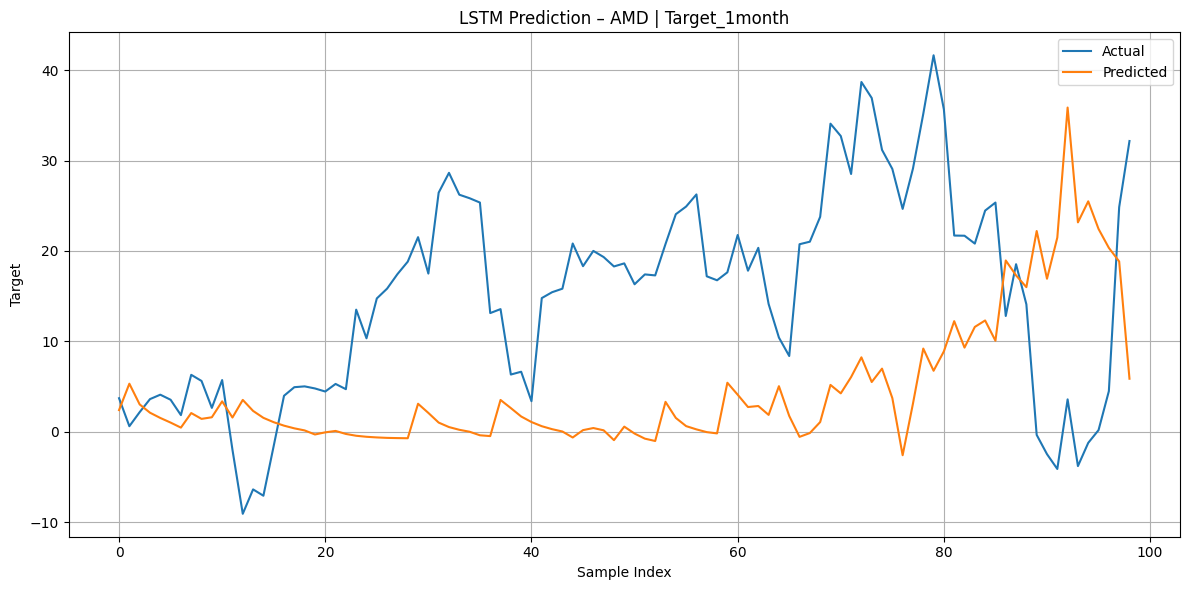

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

[AMD] Target: Target_1year
MAE : 34.7498
RMSE: 44.0383
R²   : -0.2700


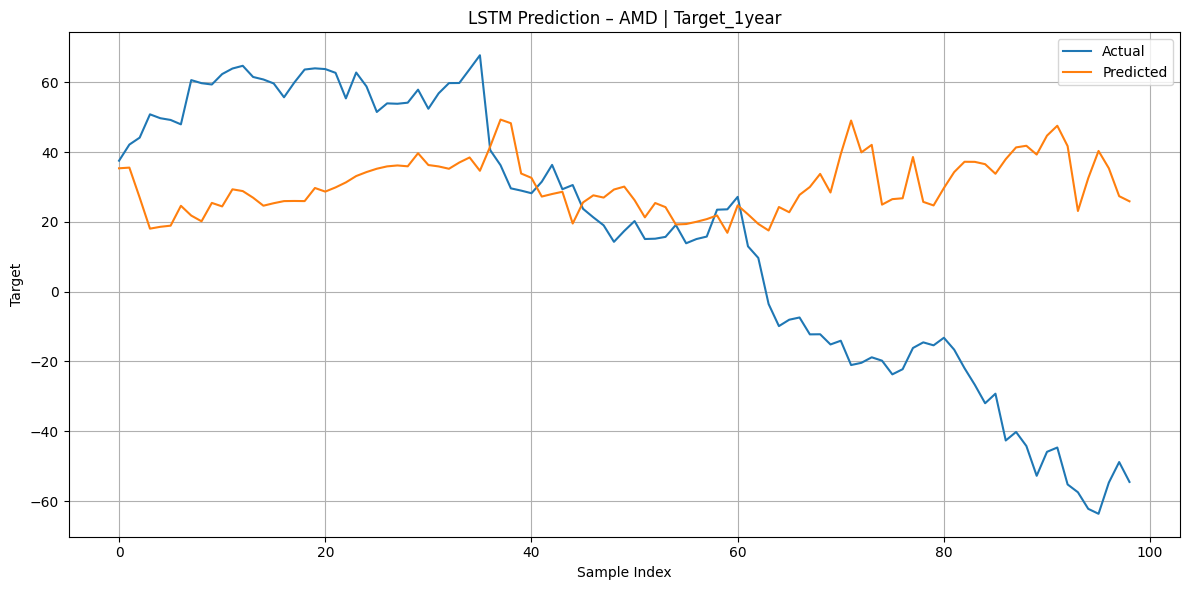

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step

[AMZN] Target: Target_1day
MAE : 4.9532
RMSE: 9.3279
R²   : -10.6324


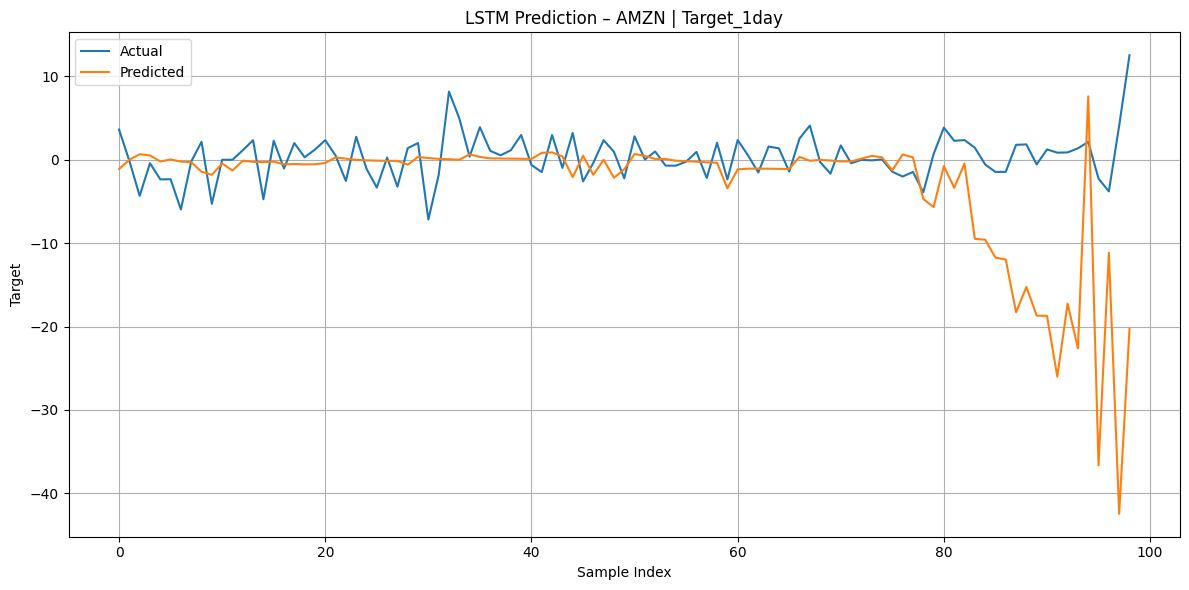

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AMZN] Target: Target_1week
MAE : 8.0374
RMSE: 14.7311
R²   : -5.2476


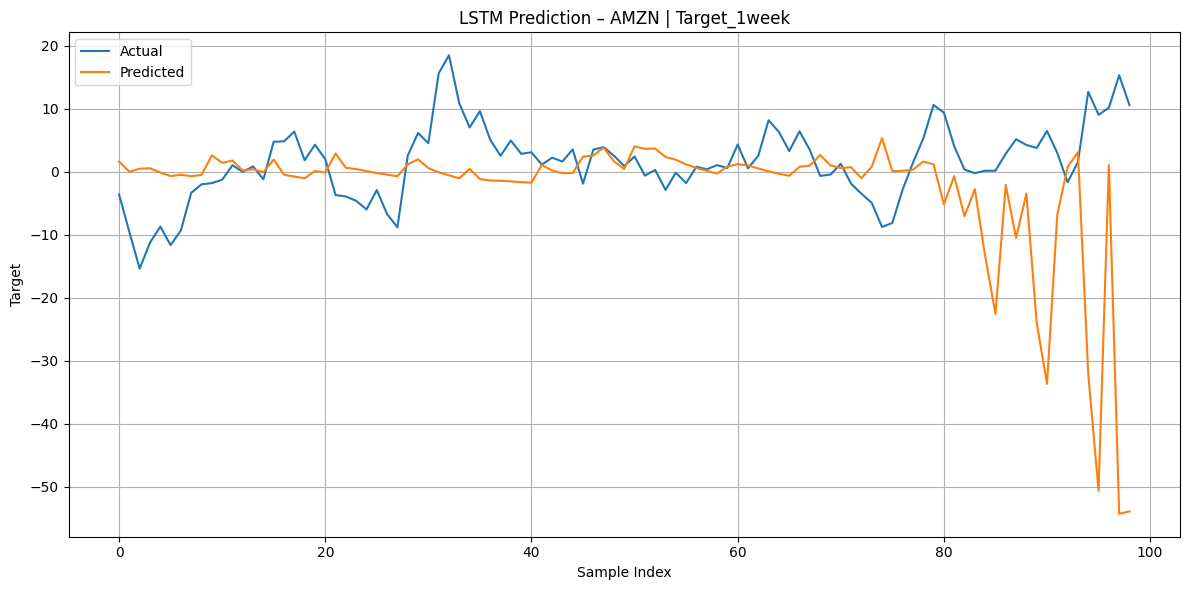

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

[AMZN] Target: Target_1month
MAE : 20.5132
RMSE: 26.5136
R²   : -8.3963


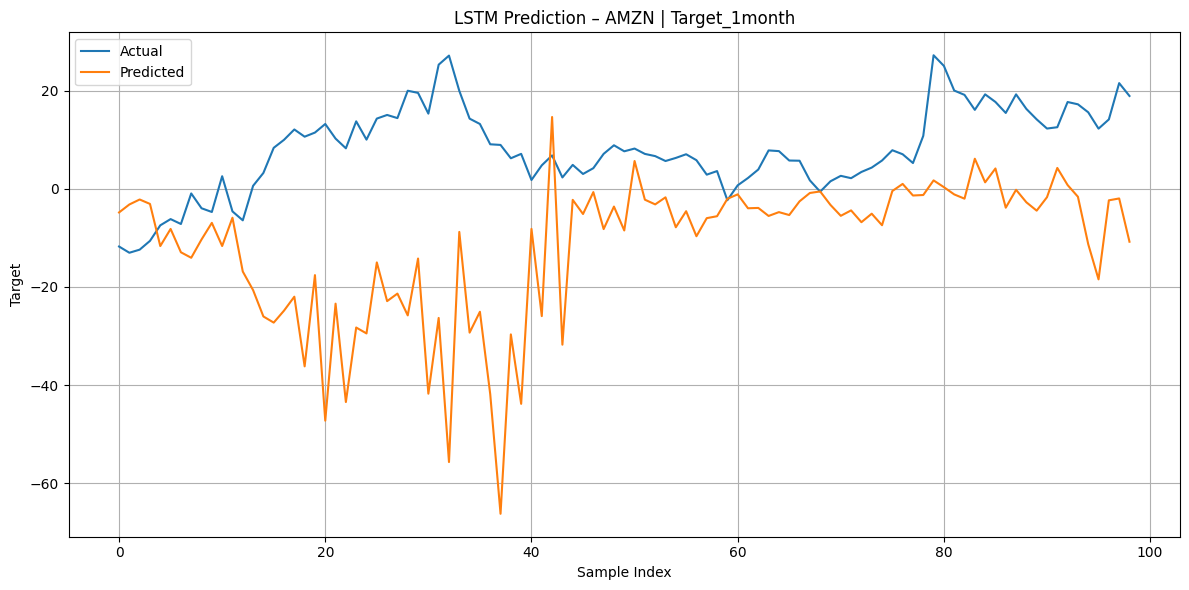

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AMZN] Target: Target_1year
MAE : 23.5148
RMSE: 29.6733
R²   : -7.5818


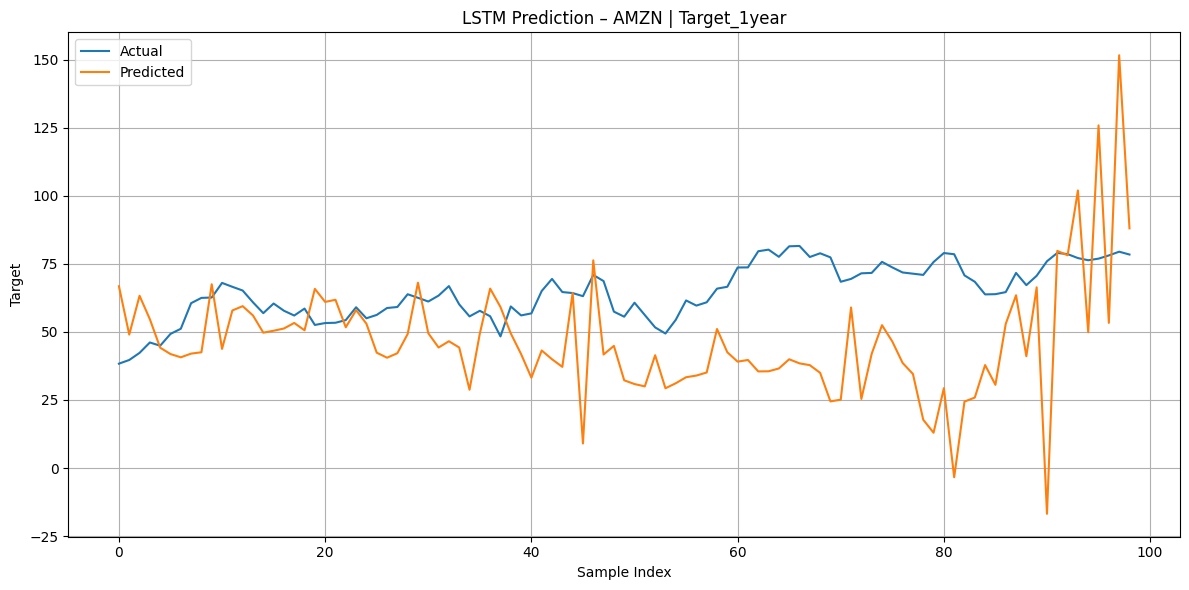

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

[AVGO] Target: Target_1day
MAE : 33.2875
RMSE: 54.9863
R²   : -768.6478


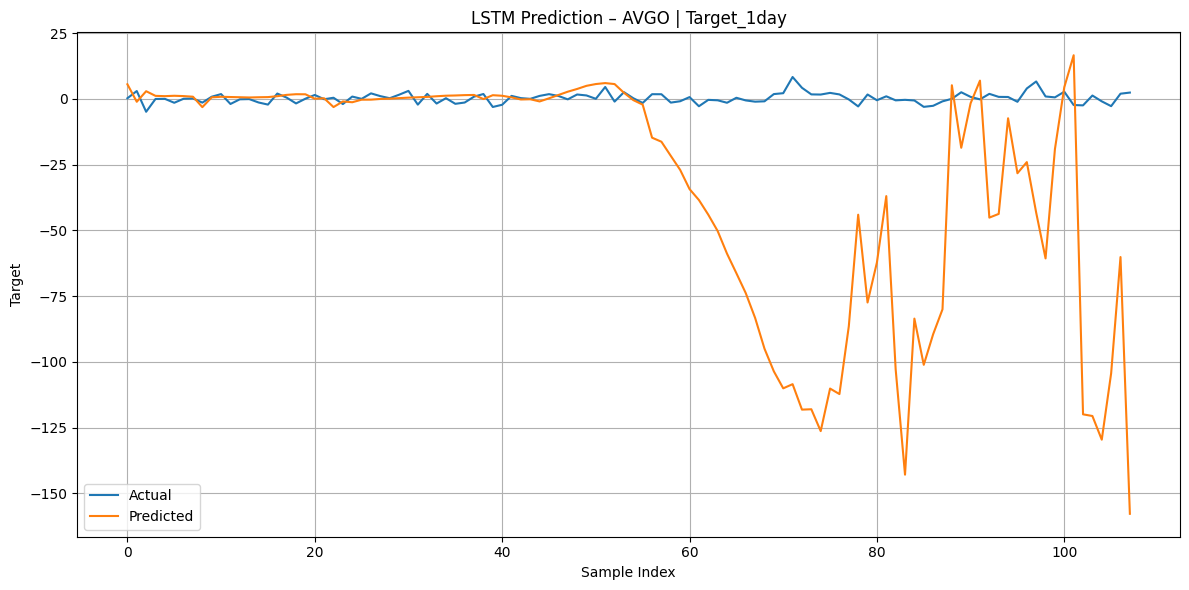

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AVGO] Target: Target_1week
MAE : 5.0264
RMSE: 6.3180
R²   : -0.3204


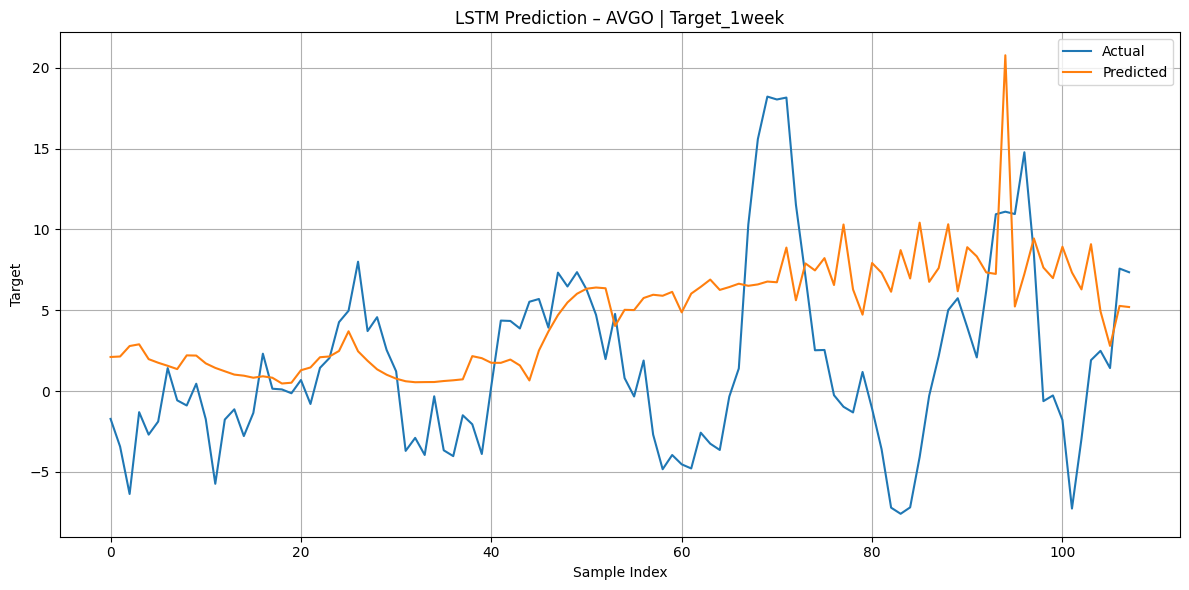

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AVGO] Target: Target_1month
MAE : 17.9172
RMSE: 25.3815
R²   : -13.6980


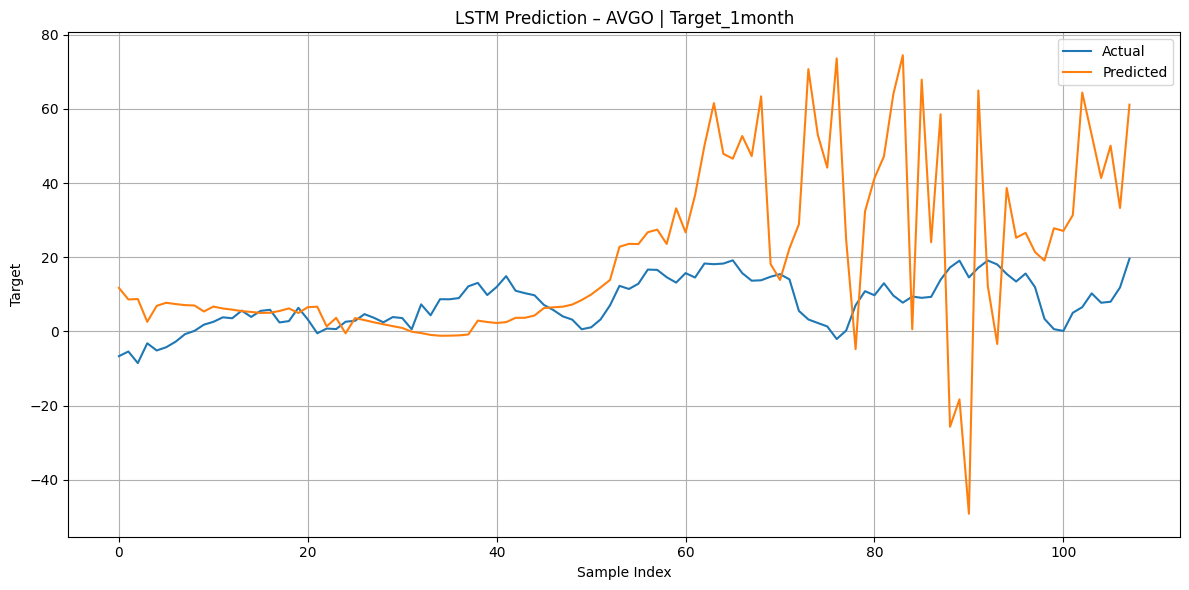

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

[AVGO] Target: Target_1year
MAE : 46.1238
RMSE: 52.3684
R²   : -5.9321


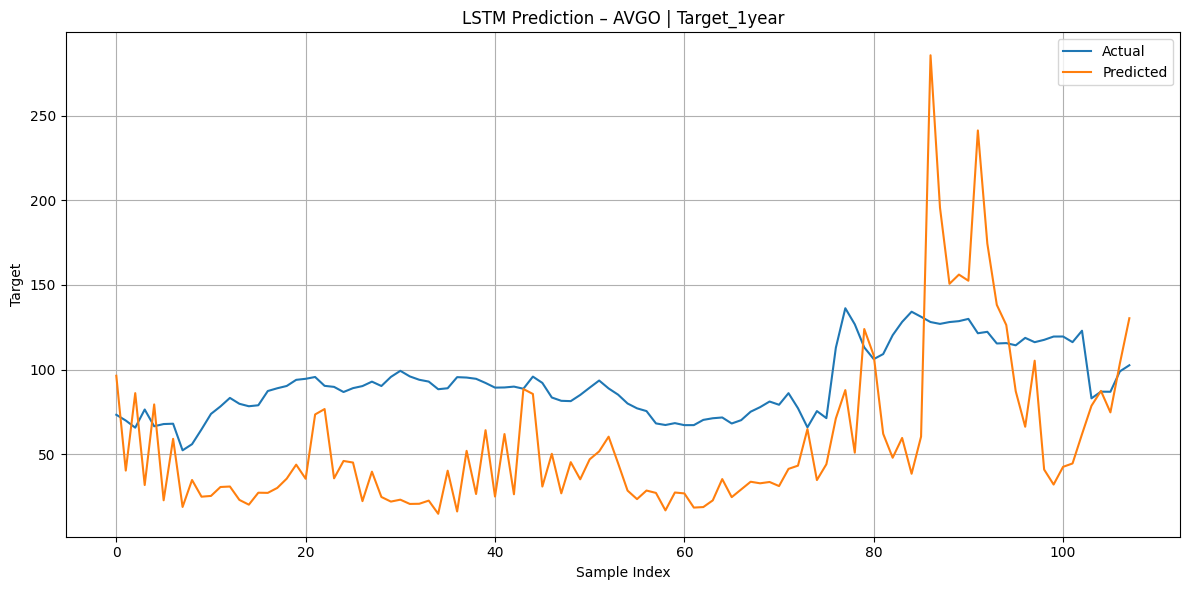

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

[GOOGL] Target: Target_1day
MAE : 10.4999
RMSE: 23.4777
R²   : -86.7590


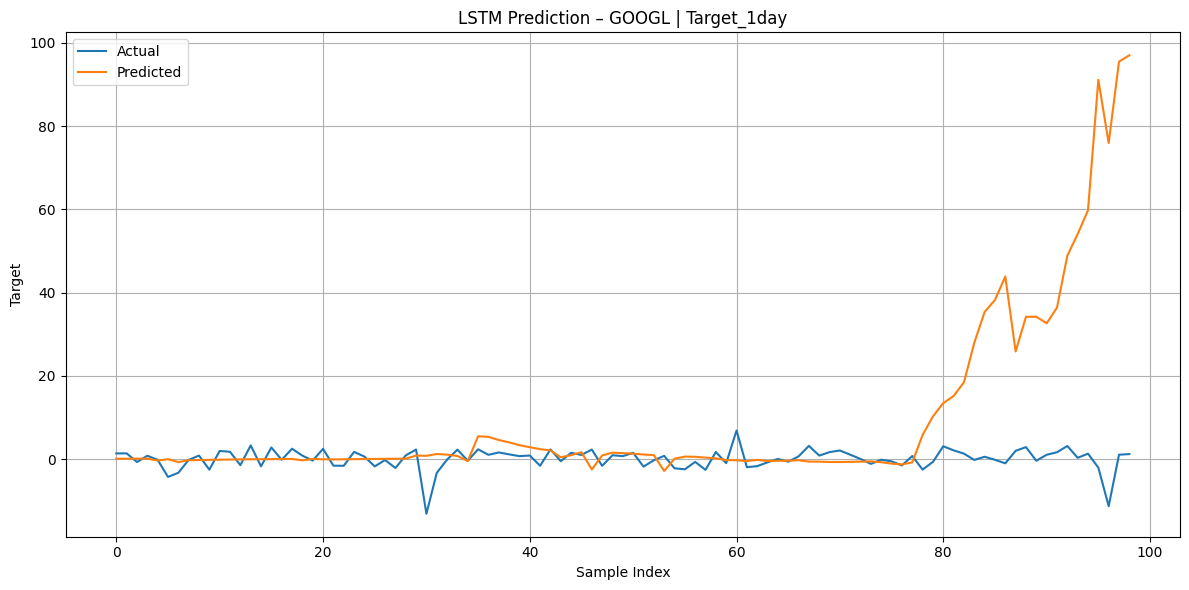

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

[GOOGL] Target: Target_1week
MAE : 34.7546
RMSE: 95.2795
R²   : -282.8140


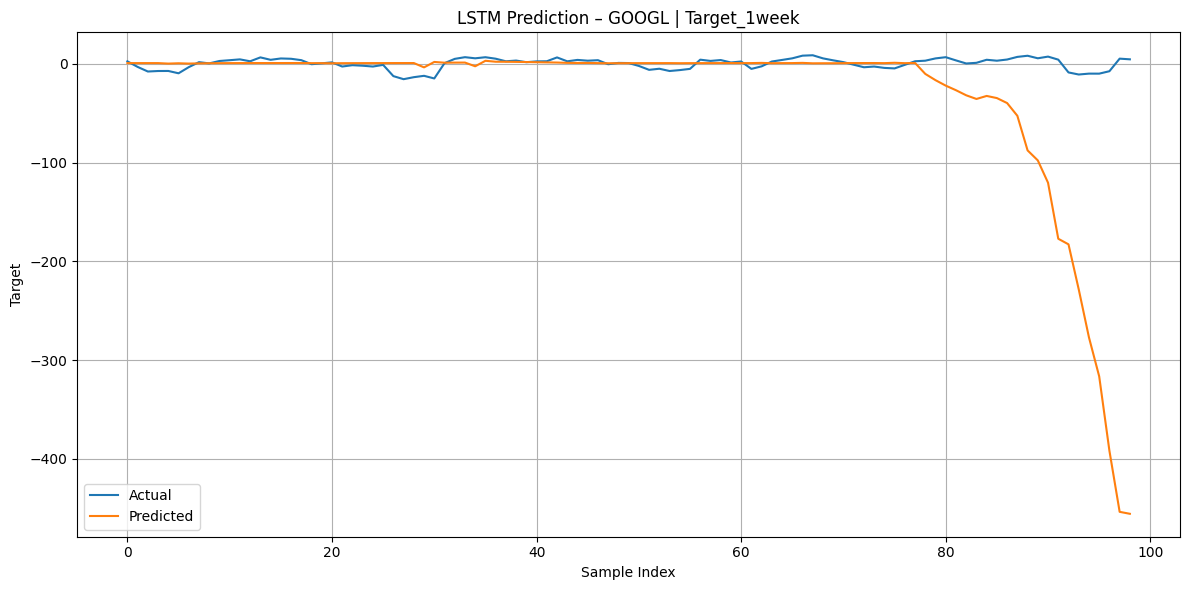

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step

[GOOGL] Target: Target_1month
MAE : 33.1287
RMSE: 83.5830
R²   : -146.0911


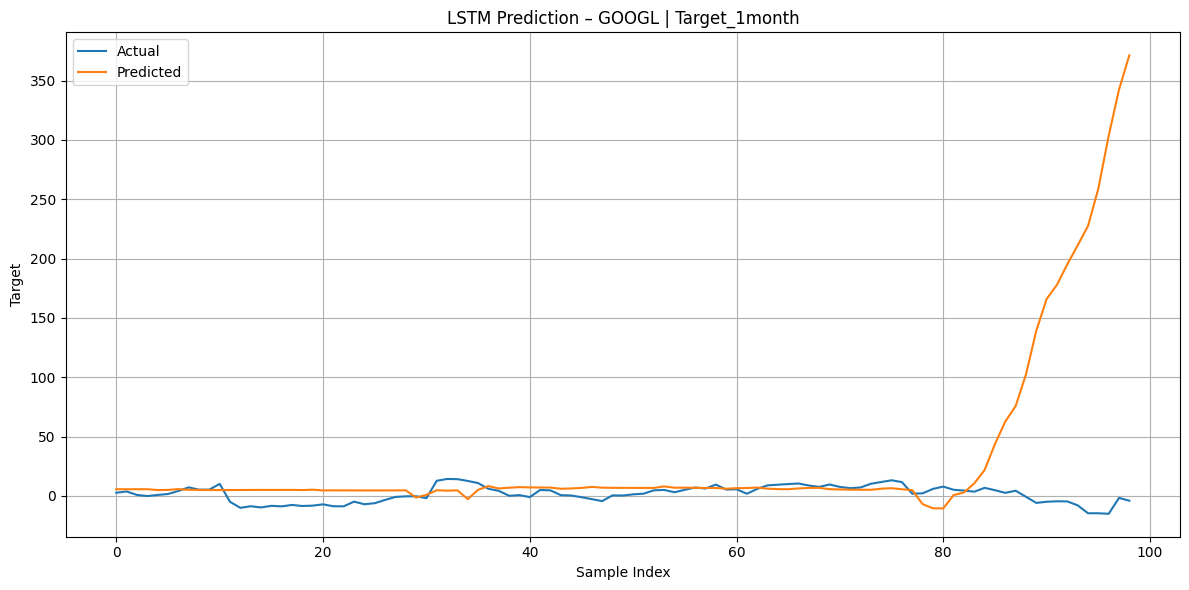

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

[GOOGL] Target: Target_1year
MAE : 47.8543
RMSE: 106.5416
R²   : -77.7106


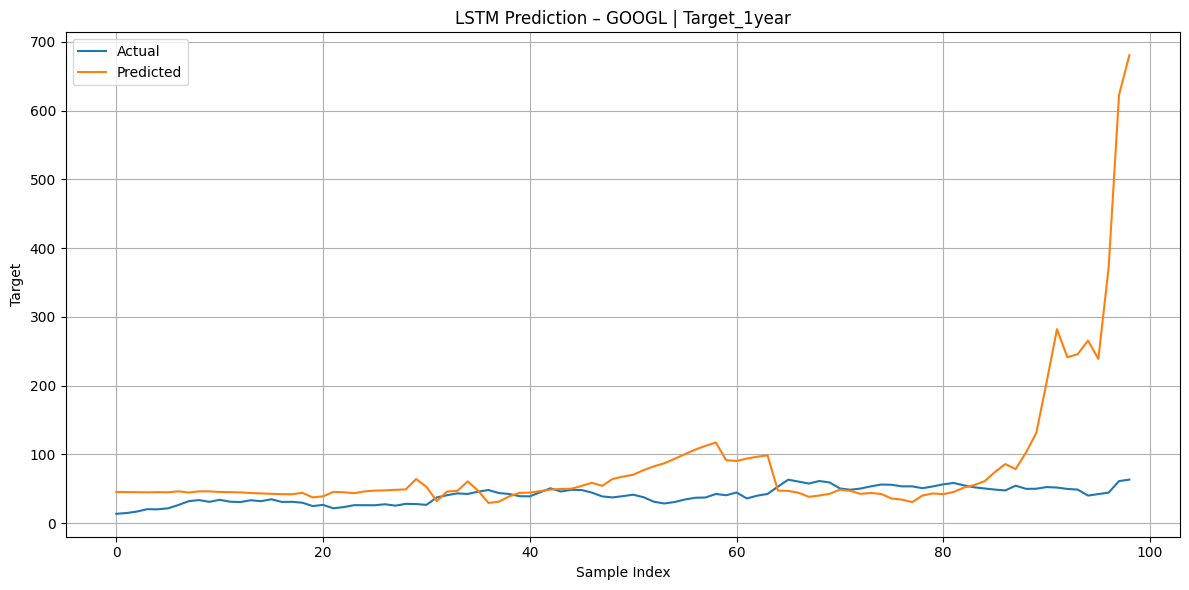

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

[META] Target: Target_1day
MAE : 5.2992
RMSE: 9.0740
R²   : 0.0876


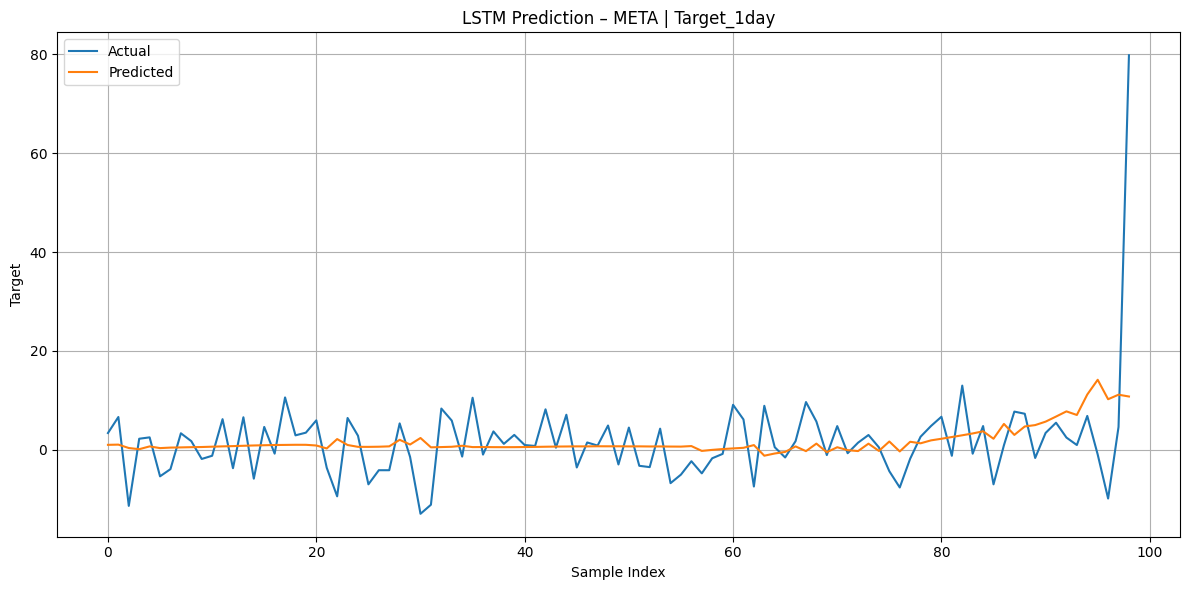

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

[META] Target: Target_1week
MAE : 12.3229
RMSE: 18.8690
R²   : -0.0637


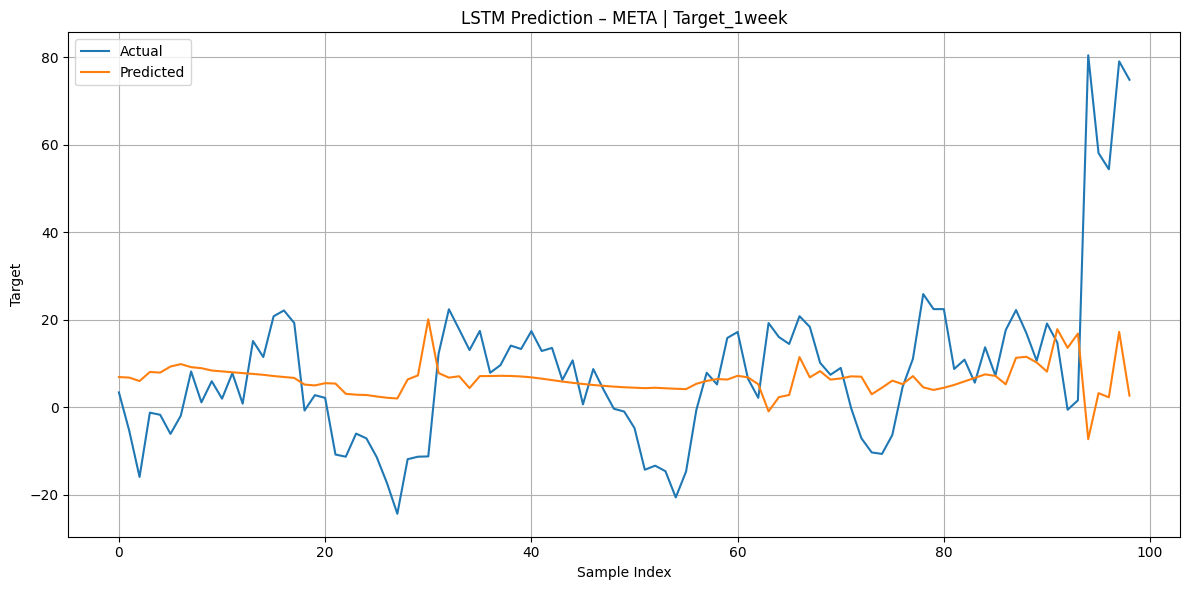

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

[META] Target: Target_1month
MAE : 30.8332
RMSE: 44.8241
R²   : -0.6542


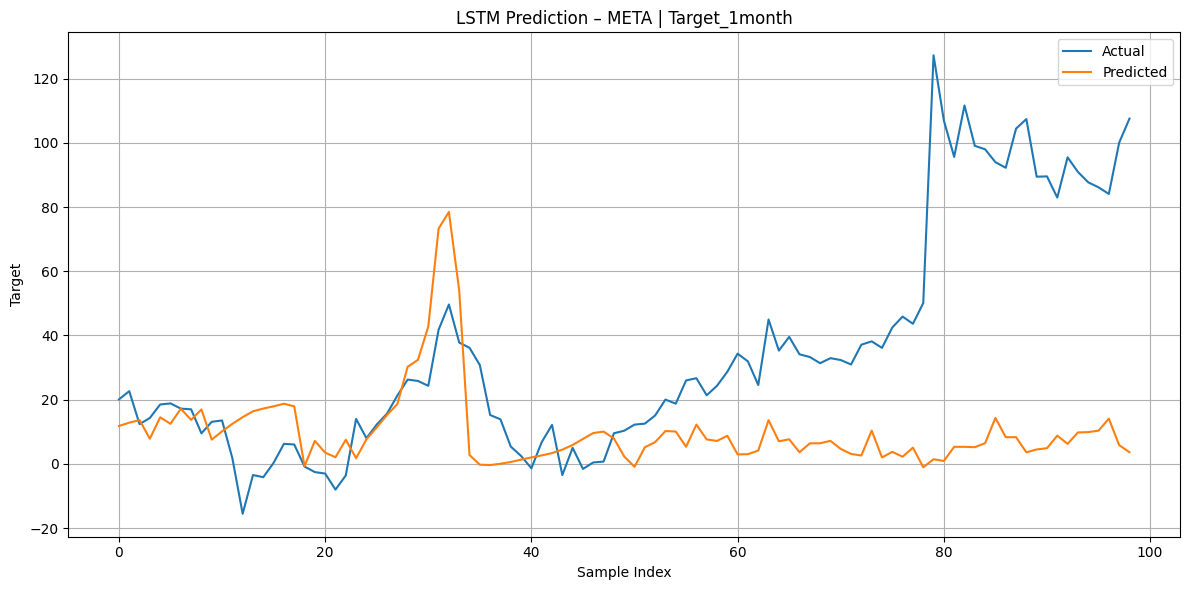

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

[META] Target: Target_1year
MAE : 149.1403
RMSE: 156.6331
R²   : -50.1587


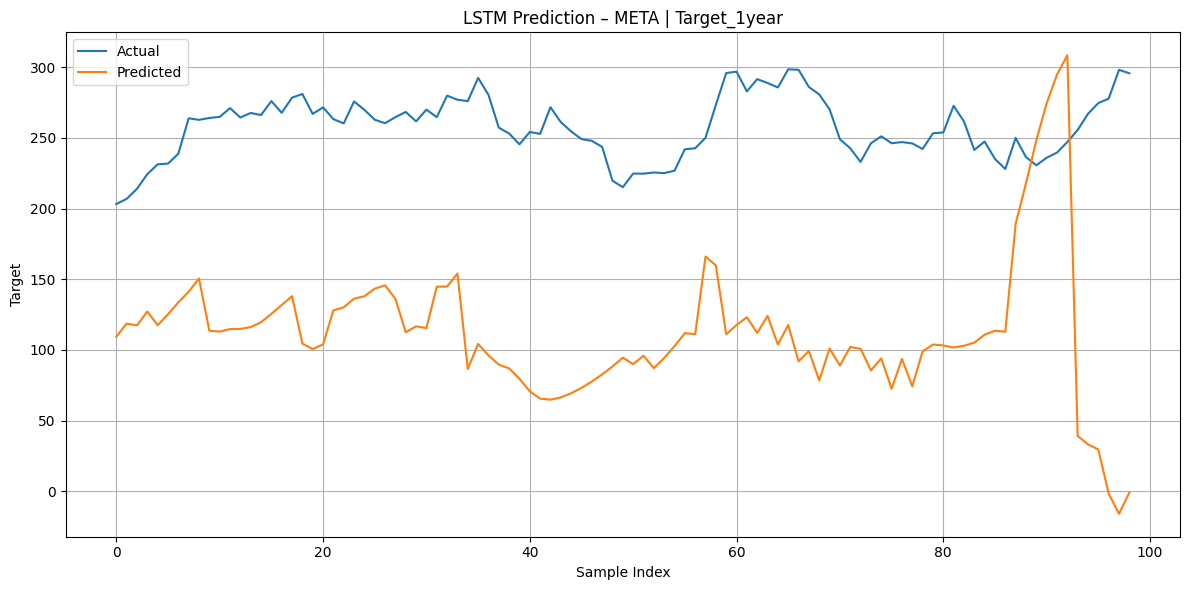

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

[MSFT] Target: Target_1day
MAE : 21.8984
RMSE: 31.1426
R²   : -54.6337


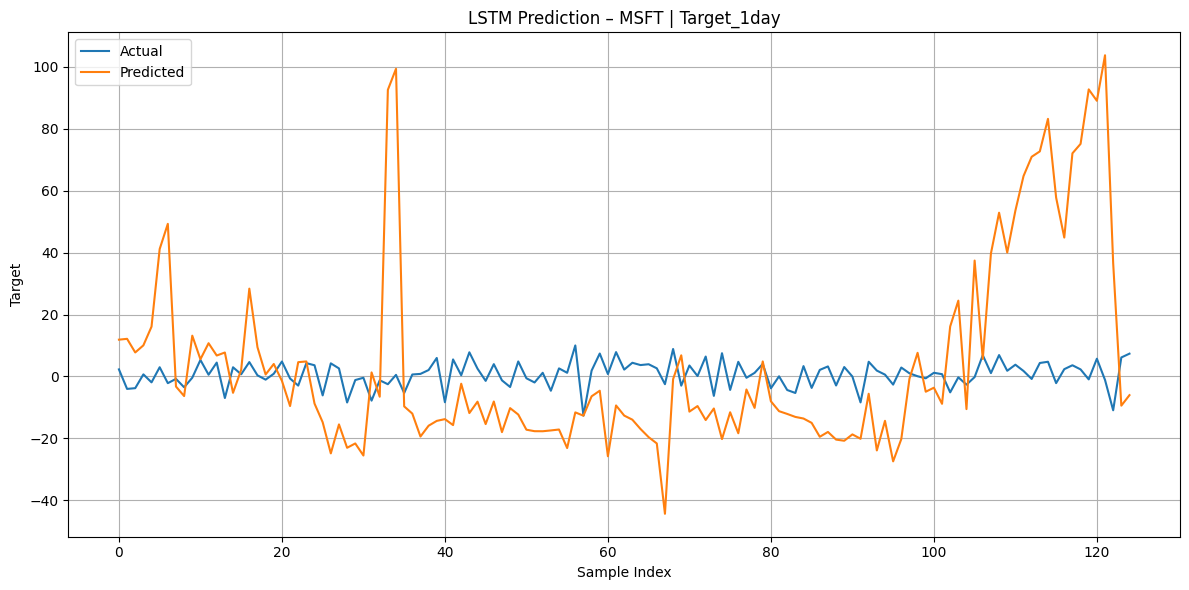

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

[MSFT] Target: Target_1week
MAE : 49.7170
RMSE: 62.1772
R²   : -55.4963


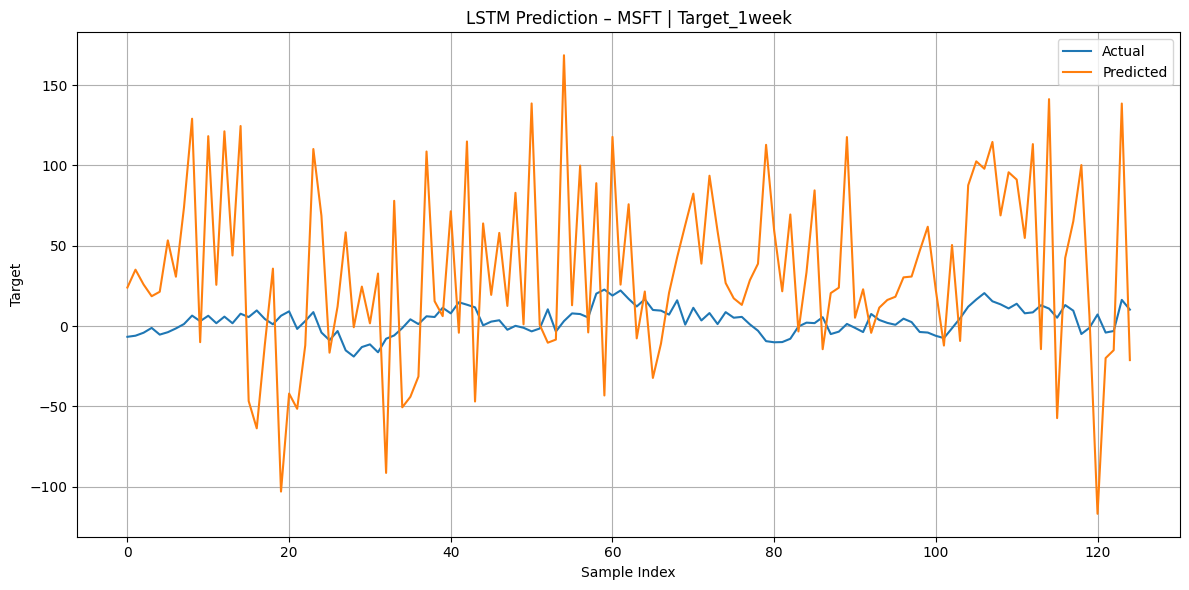

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

[MSFT] Target: Target_1month
MAE : 35.4546
RMSE: 45.9043
R²   : -6.4709


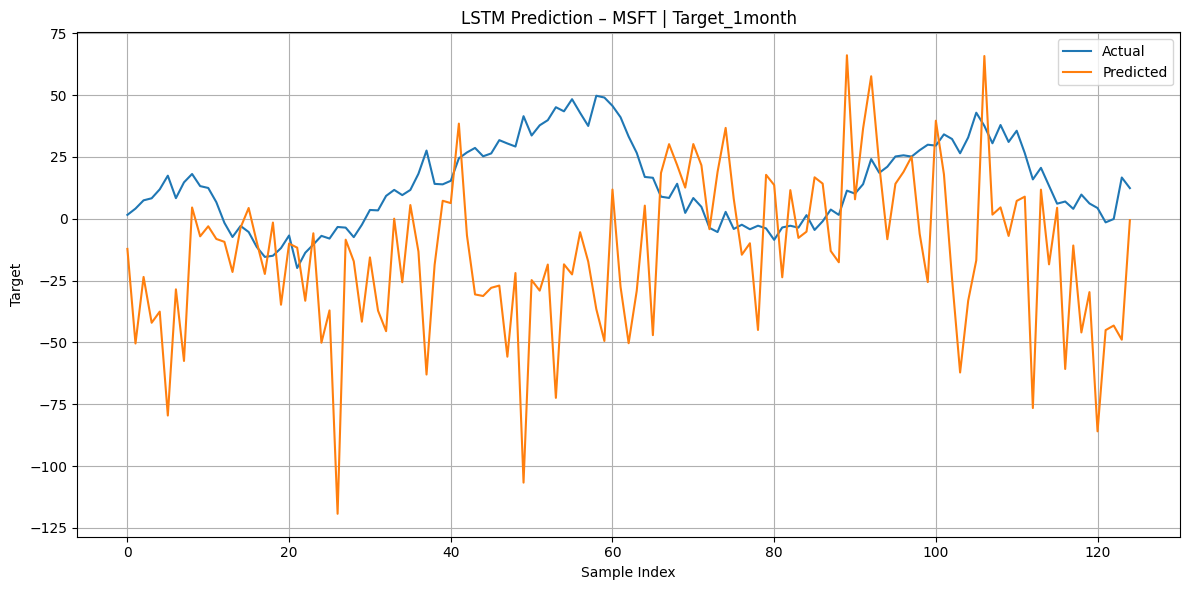

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

[MSFT] Target: Target_1year
MAE : 71.6778
RMSE: 84.0511
R²   : -10.3452


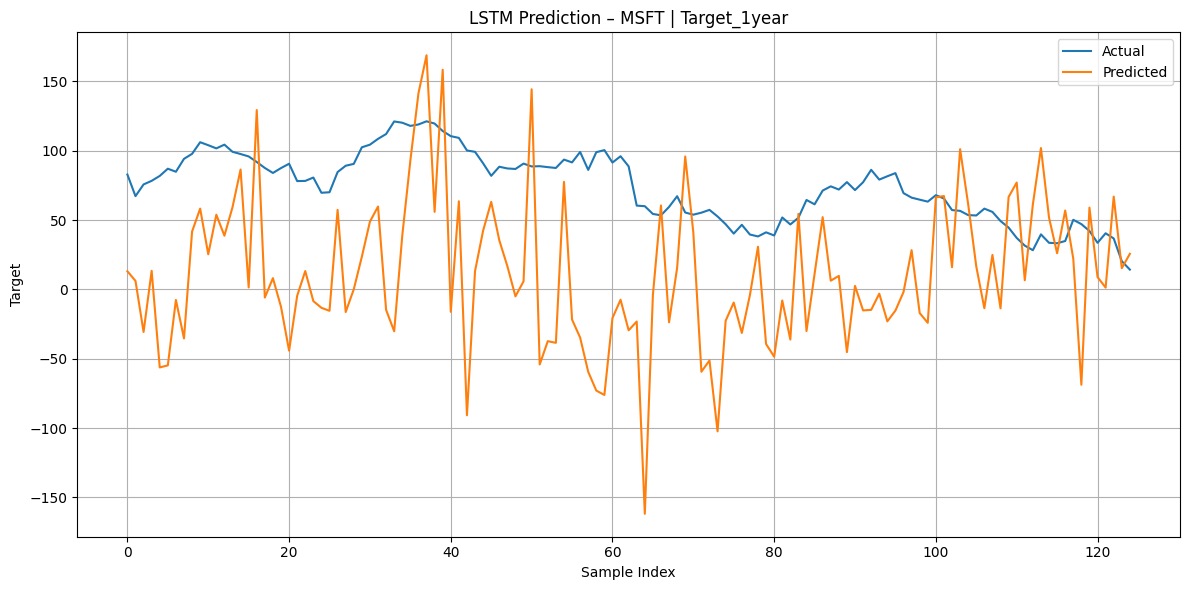

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step

[NVDA] Target: Target_1day
MAE : 1.3984
RMSE: 5.8208
R²   : -30.8044


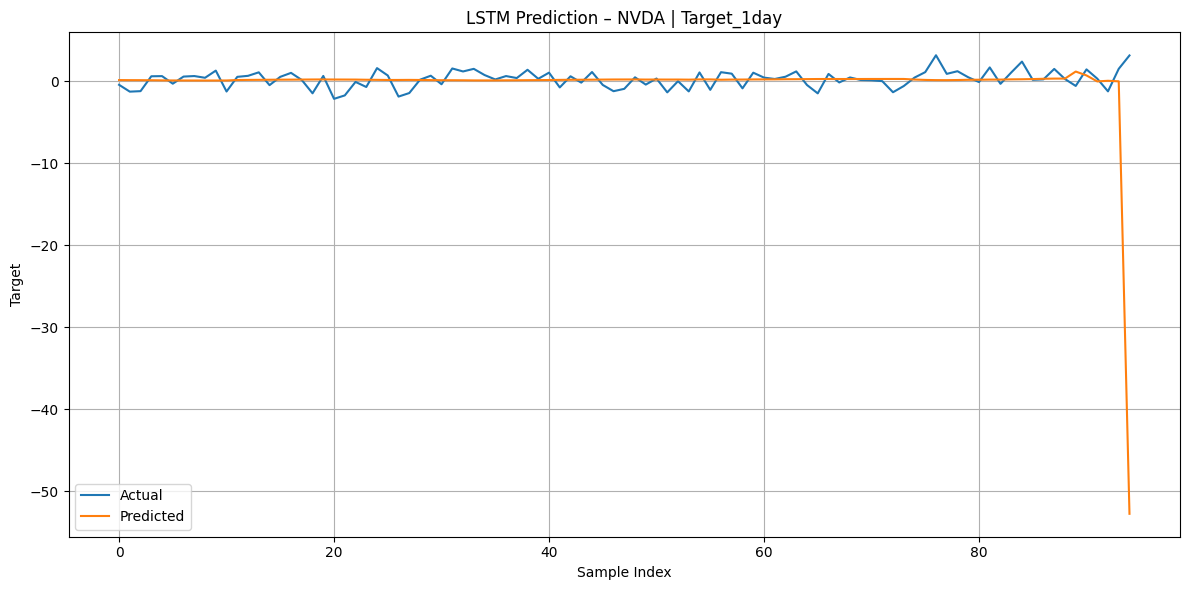

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

[NVDA] Target: Target_1week
MAE : 2.7025
RMSE: 3.3881
R²   : -0.4951


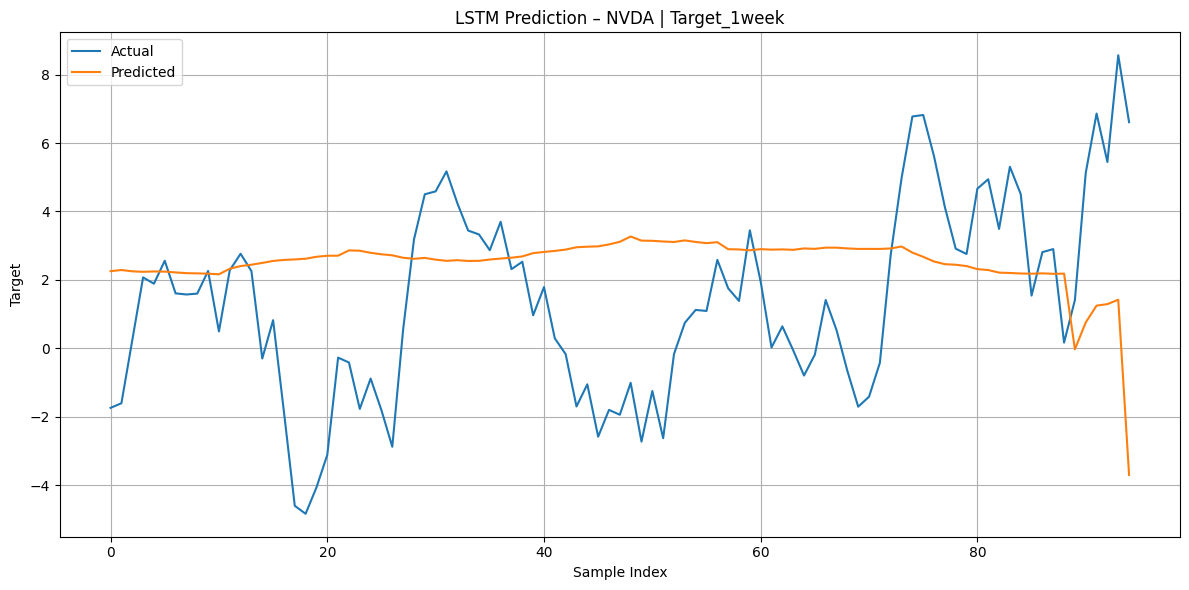

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step

[NVDA] Target: Target_1month
MAE : 7.3198
RMSE: 8.4313
R²   : -0.5757


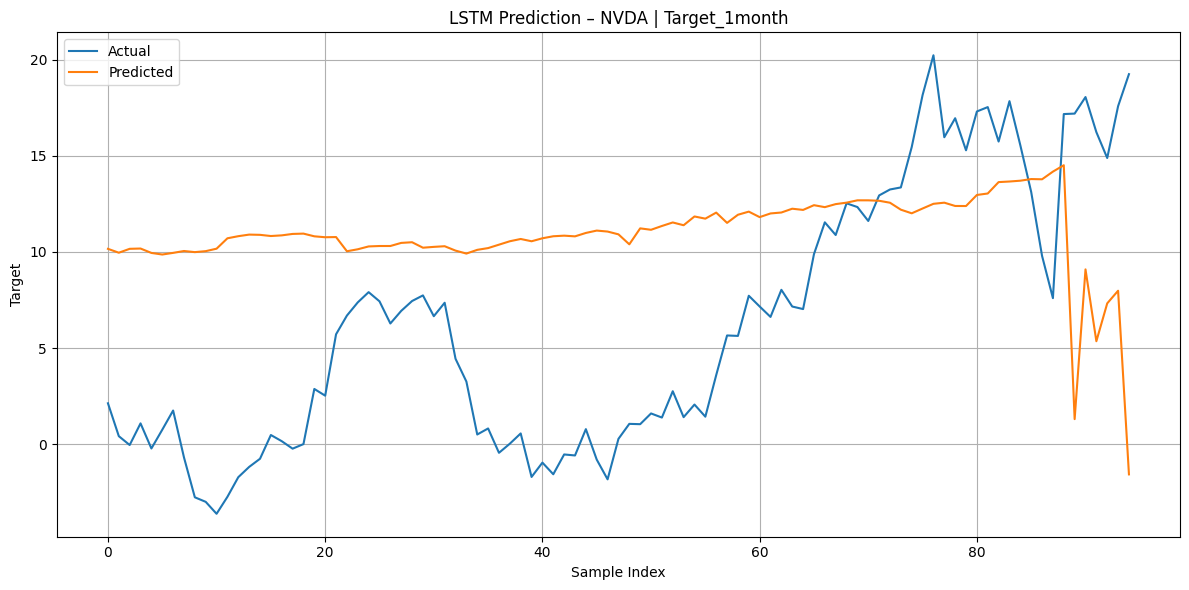

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

[NVDA] Target: Target_1year
MAE : 8.7429
RMSE: 12.9139
R²   : -0.6239


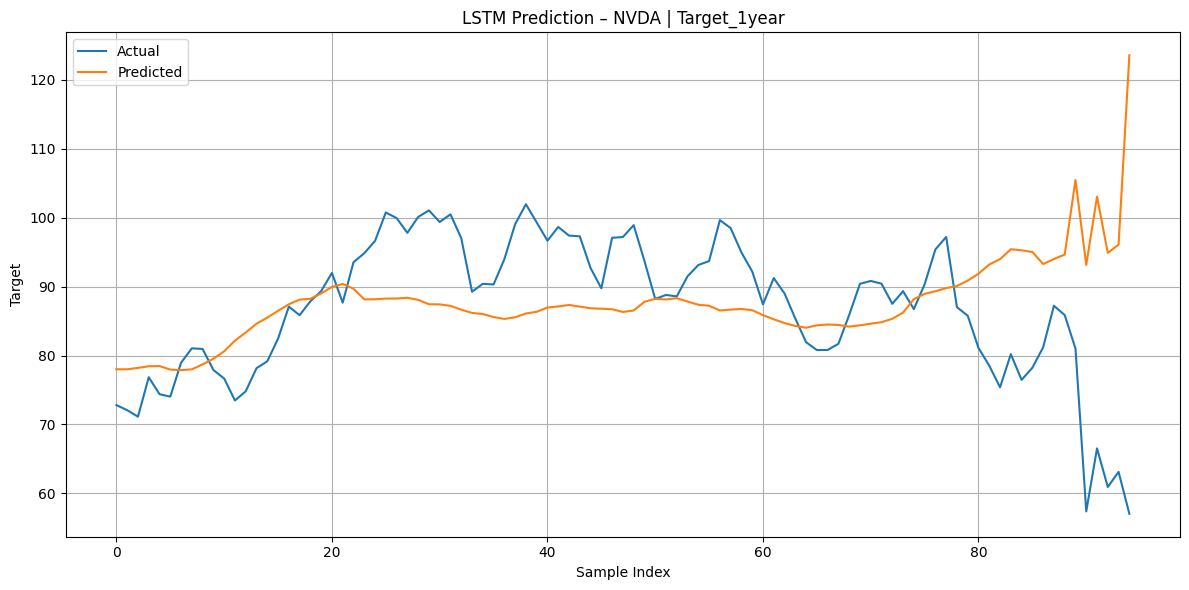

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

[ORCL] Target: Target_1day
MAE : 8.6567
RMSE: 9.9653
R²   : -14.8258


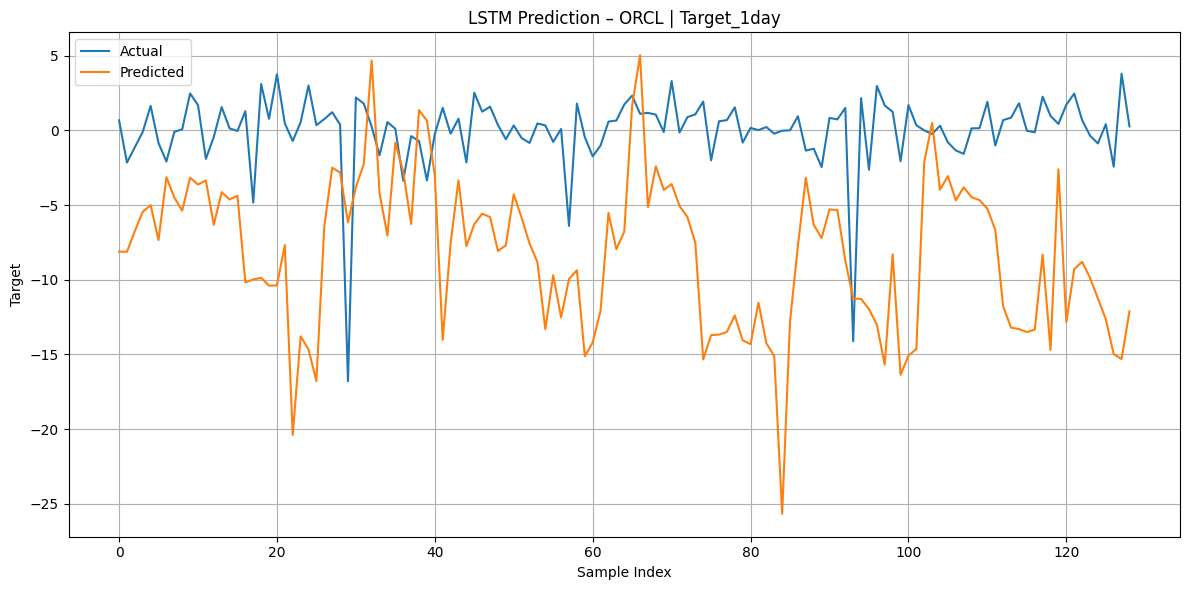

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

[ORCL] Target: Target_1week
MAE : 10.6719
RMSE: 14.4387
R²   : -7.6322


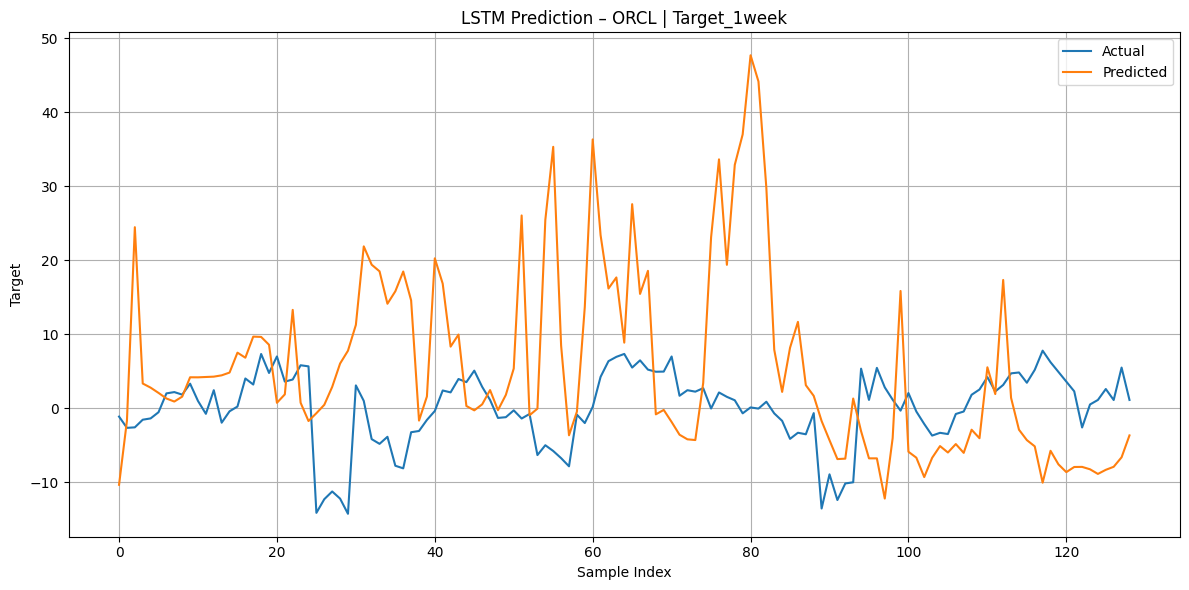

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

[ORCL] Target: Target_1month
MAE : 57.4782
RMSE: 58.3875
R²   : -41.9039


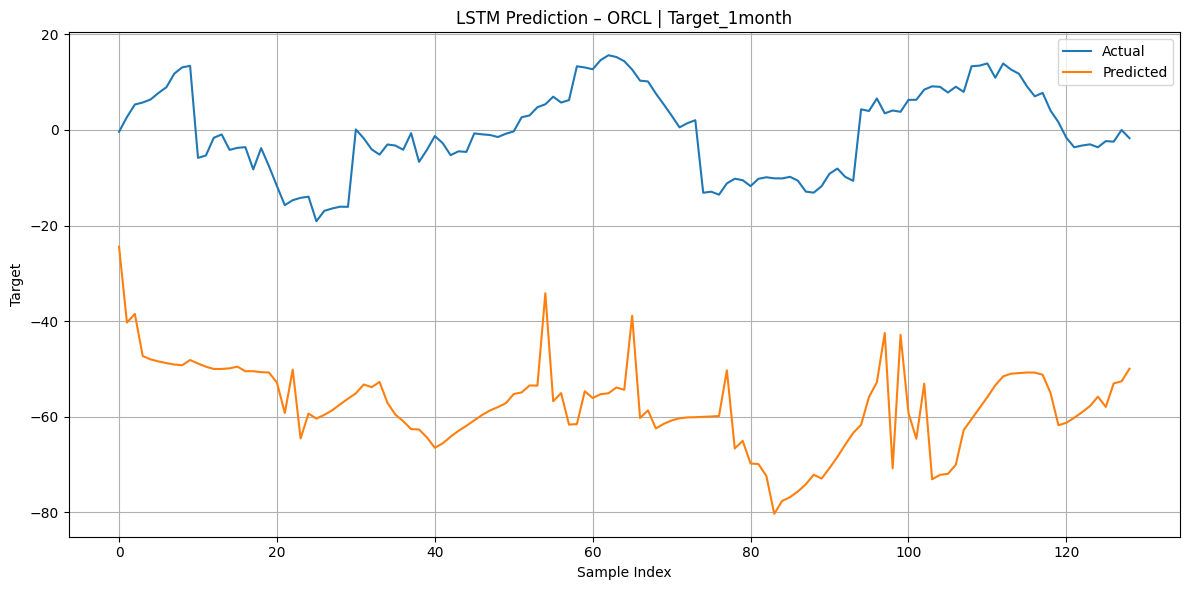

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

[ORCL] Target: Target_1year
MAE : 28.4227
RMSE: 32.4917
R²   : -1.4995


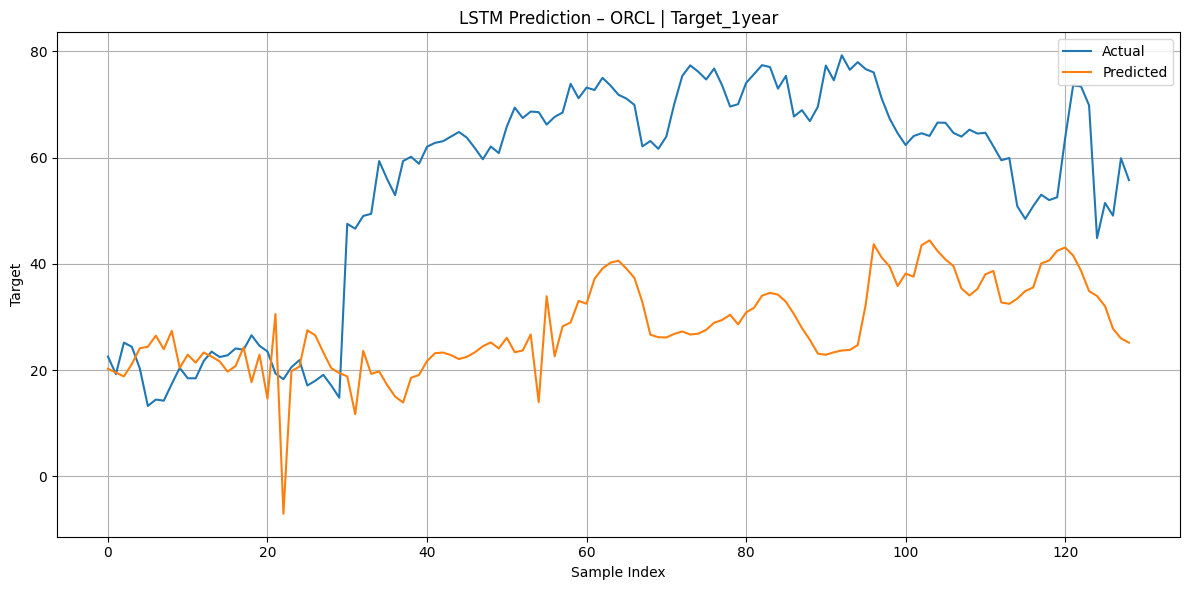

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

[TSLA] Target: Target_1day
MAE : 5.1133
RMSE: 6.7889
R²   : -0.1137


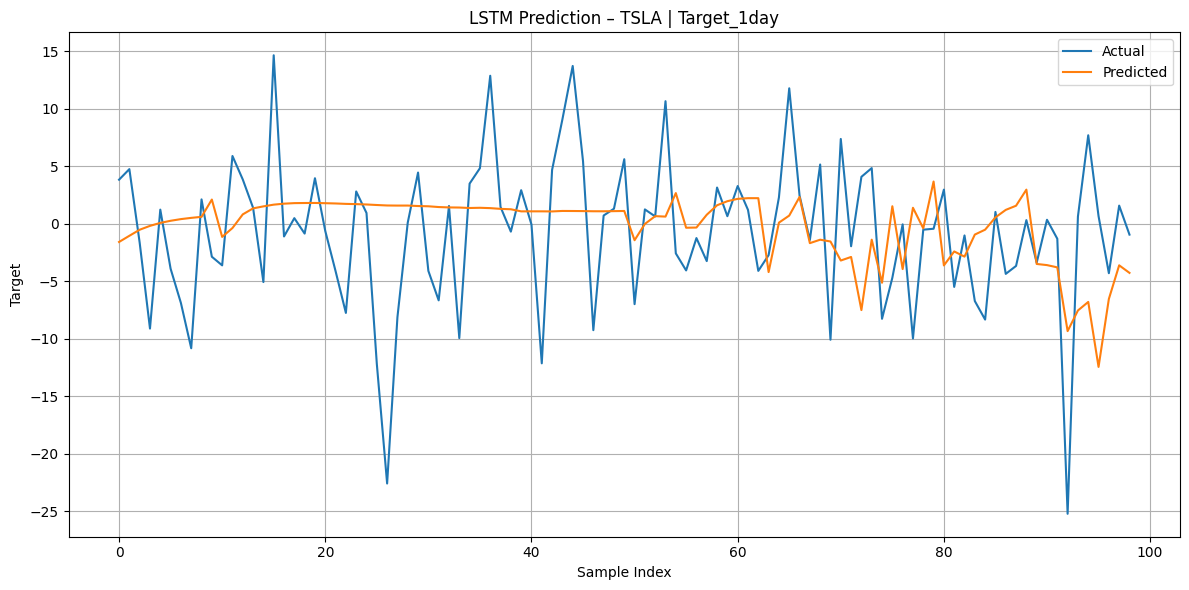

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step

[TSLA] Target: Target_1week
MAE : 12.3577
RMSE: 15.9043
R²   : -0.1415


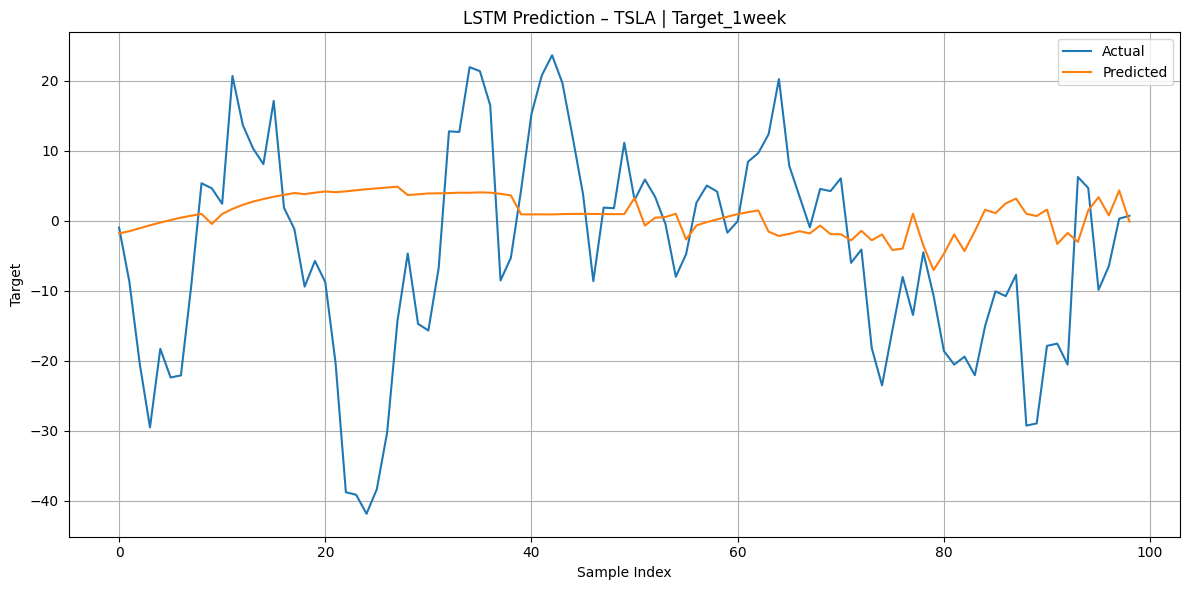

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

[TSLA] Target: Target_1month
MAE : 30.3666
RMSE: 35.7219
R²   : -0.4513


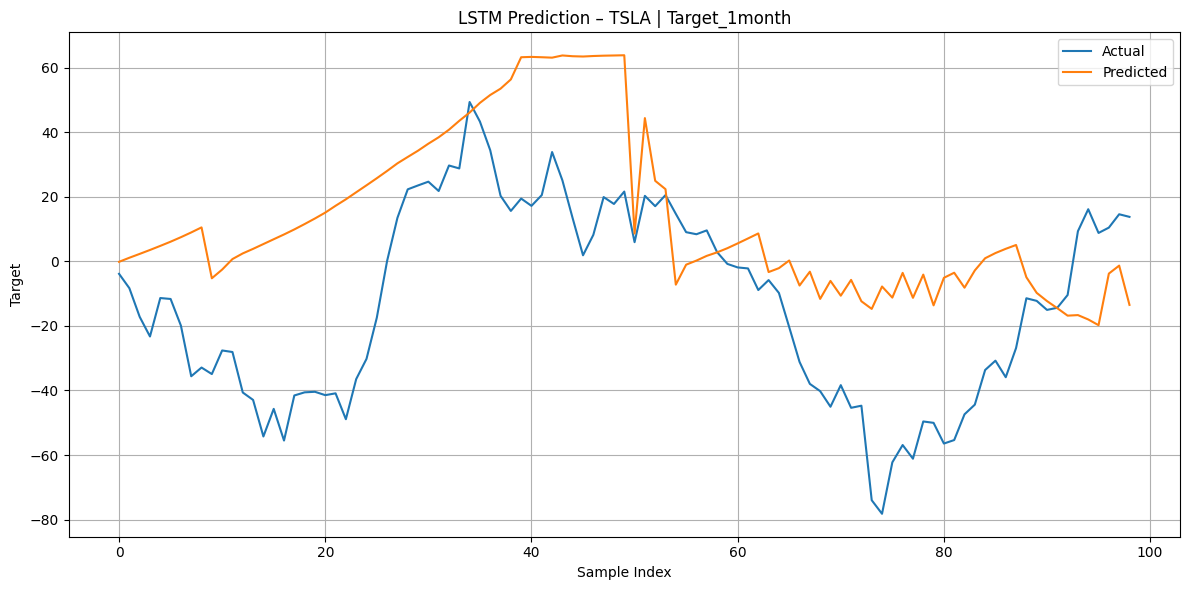

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

[TSLA] Target: Target_1year
MAE : 101.7581
RMSE: 125.7088
R²   : -1.0620


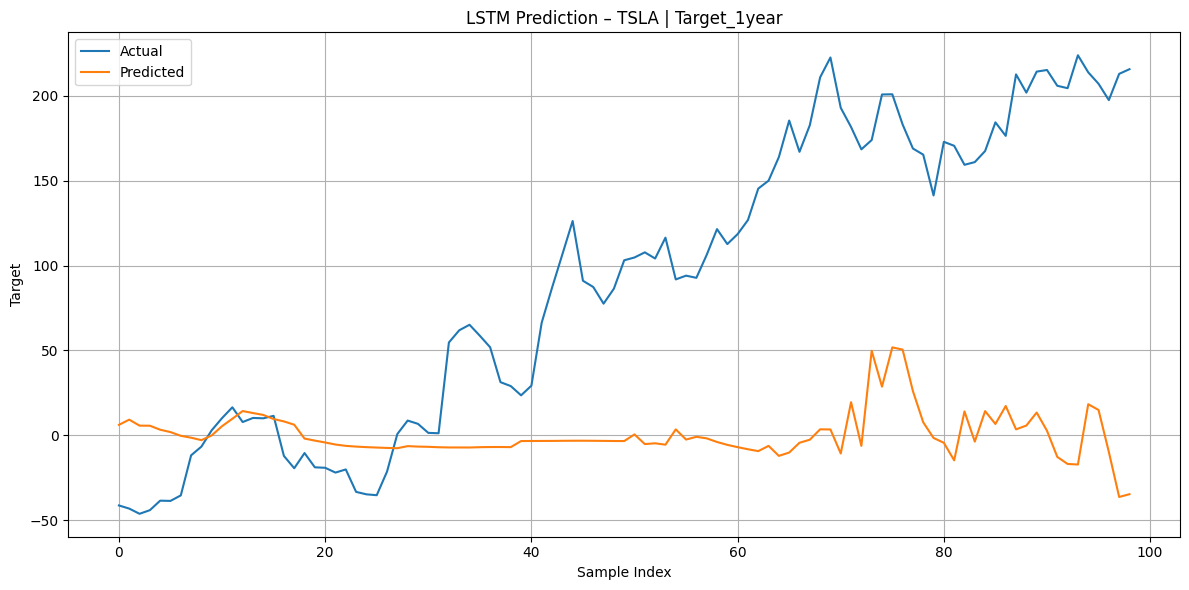

In [58]:
tickers_to_run = df['Ticker'].unique()
targets = ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']

for ticker in tickers_to_run:
    for target in targets:
        run_lstm_by_ticker(df, ticker, target)
